# <span style="color:blue"> Multilabel text classification: case study cohort selection</span> 


**Table of contents**:
1. [Introduction](#CS_INTRO).
2. [Project libraries](#CS_LIB).
3. [Hyperparameters](#CS_HP).
4. [Experimental desing](#CS_HD).
5. Data set preprocessing and analysis.
    - [Normalization](#CS_NORMALIZATION).
    - [Word encoding](#CS_WORD_ENCODING).
    - [Padding](#CS_PADDING).
    - [Characteristics](#CS_CHARACTERISTICS).
    - [Loaders](#CS_LOADER).
6. [Learning models](#CS_MODELS).
    - [Stacked](#CS_STACKED)
    - [Dilated](#CS_YOON)
    - [Bidirectional Encoder Representations from Transformers (BERT)](#CS_BERT).
    - [Inception](#CS_Inception).
7. [Model assessment and selection](#CS_ASSESMENT)
8. [Model evaluation](#CS_METRICS)

**TODO**:
- Implement oversampling and change the cost function.
- Is the loss funtion working correctly?
- How do I load the best pretained mode?
- Is it better to use pretained word embeddings instead of the ones provided by the library?
- Correct the return values of the validation phase [in progress].
- Complete the metrics section [in progress].
- Use pretrained word embeddings

(C) Adán Hirales Carbajal

## <a name="CS_INTRO">1. <span style="color:blue">Introduction</span></a>

In 2018 Stubs et.al. (2019) held the National NLP Clinical Challenge that focused on identifying which patients in a corpus of medical records meet or not a selection criterion. Medical records correspond to patients with some level of diabetes and at risk of heart disease. Each record was annotated to indicate if a criterion is met or not. Criterions include:
- Drug abuse, current or past.
- Current alcohol use over weekly-recommended limits
- Patient must speak English
- Patient must make their own medical decisions
- History of intra-abdominal surgery, small or large. Intestine resection or small bowel obstruction
- Major diabetes-related complication.
- Advanced cardiovascular disease
- Myocardial infarction in the past 6 months
- Diagnosis of ketoacidosis in the past year
- Taken a dietary supplement (excluding Vitamin D) in the past 2 months
- Use of aspirin to prevent myocardial infarction
- Any HbA1c value between 6.5 and 9.5%
- Serum creatinine > upper limit of normal

Two annotators, with medical expertise, evaluated the dataset. In average, they agreed on 84.9% of the cases.  Annotation granularity was at document level. The corpus consists of 288 patient records with 2-5 medical notes per patient, partition in 202 records corresponding to the training set and 86 records to the test set. The goal of the cohort selection problem is to facilitate the identification of patients who meet a subset of criterions. 


## <a name="CS_LIB">2. <span style="color:blue">Project libraries</span></a>

In [1]:
import os
import glob
import math
import re
import pandas_read_xml as pdx
import numpy as np
import pandas as pd
from pandas_read_xml import flatten, fully_flatten, auto_separate_tables
from collections import Counter
from nltk.corpus import stopwords

# plotting
from bokeh.io import output_notebook, show # Bokeh visualization
from bokeh.plotting import figure

# For polymorphism
from abc import ABCMeta, abstractmethod  

# Data manipulation
from torch.utils.data import Dataset, DataLoader

# CNN
import torch
import torch.nn as nn
import torch.optim as optim                    # optimizer and loss function
import torch.nn.functional as F                # activation functions

# Experiental desing
import pyDOE2

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sn

output_notebook()
%matplotlib inline

Loading BokehJS ...

## 3. <a name="CS_HP"><span style="color:blue">Hyperparameters</span></a>

You must solicit access to the dataset at the [Department of Biomedical Informatics](https://portal.dbmi.hms.harvard.edu/) (DBMI) in the Blavatnik Institute at Harvard Medical School. Patient medical notes come in XML format in two datasets (training and test). I further partition the test set into a test and validation sets.

In [2]:
# Experimental setup parameters. Hyperparameters set to -1 are define at runtime.
hp = {
    "train_raw"            : r'E:\Datasets\nlp\cohort\train\*.xml',
    "valid_raw"            : r'E:\Datasets\nlp\cohort\valid\*.xml',
    "test_raw"             : r'E:\Datasets\nlp\cohort\test\*.xml',
    "train_unnormalized"   : r'E:\Datasets\nlp\cohort\untrain.pkl',
    "valid_unnormalized"   : r'E:\Datasets\nlp\cohort\unvalid.pkl',
    "test_unnormalized"    : r'E:\Datasets\nlp\cohort\untest.pkl',
    "train"                : r'E:\Datasets\nlp\cohort\ntrain.pkl',
    "valid"                : r'E:\Datasets\nlp\cohort\nvalid.pkl',
    "test"                 : r'E:\Datasets\nlp\cohort\ntest.pkl',
    "filters"              : ['LREGEX','RMCC','RMPC','RWSP','TTLC','TKNZ','RMSW'],
    "normalize"            : ['TEXT'],
    "padding"              : ['end'],       # start, end, or none
    "vocabulary_size"      : -1,            # computed by helper: 
    "text_length"          : -1,            # computed by helper:
    "batch_size"           : 5,
    "embedding_size"       : 150, 
    "kernel_size"          : [2, 3, 4, 5],     # kernel or convolution filter size
    "k-kernels"            : 1,            # for each kernel size create k kernels
    "stride"               : [1, 2],        # stride
    "classes"              : 13,
    "learning_rate"        : [0.01, 0.001, 0.0001, 0.0005, 0.00001]
}




exp_design_parameters = {
    "mwf" : [10, 20, 47, 50, 60],
    "mwc" : [0.1, 0.2, 0.3, 0.4],
    "hln" : [10, 15, 20, 25, 30],
    "lr"  : [0.1, 0.01, 0.001, 0.0001]
}

## 4. <a name="CS_HD"><span style="color:blue">Experimental desing</span></a>

In [5]:
# The following class enables construction of the experimnetal model. The class is iteratable.
# It iteratively returns an experiment. 
class ExpDesign:  
    def __init__(self, exp_design):
        levels      = [len(v) for k, v in exp_design.items()]
        experiments = pyDOE2.fullfact(levels)
        self.experiments = [{key : value[int(experiment[index])] for index, (key, value) 
                              in enumerate(exp_design.items())} for experiment in experiments]
        self.index = -1
        self.num_experiments = len(self.experiments)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.index == self.num_experiments - 1:
            raise StopIteration
        self.index = self.index + 1
        return self.experiments[self.index]

In [6]:
experiments = ExpDesign(exp_design_parameters)
print("A total of {}")
for i , parameters in enumerate(experiments):
    print(parameters)

A total of {}
{'mwf': 10, 'mwc': 0.1, 'hln': 10, 'lr': 0.1}
{'mwf': 20, 'mwc': 0.1, 'hln': 10, 'lr': 0.1}
{'mwf': 47, 'mwc': 0.1, 'hln': 10, 'lr': 0.1}
{'mwf': 50, 'mwc': 0.1, 'hln': 10, 'lr': 0.1}
{'mwf': 60, 'mwc': 0.1, 'hln': 10, 'lr': 0.1}
{'mwf': 10, 'mwc': 0.2, 'hln': 10, 'lr': 0.1}
{'mwf': 20, 'mwc': 0.2, 'hln': 10, 'lr': 0.1}
{'mwf': 47, 'mwc': 0.2, 'hln': 10, 'lr': 0.1}
{'mwf': 50, 'mwc': 0.2, 'hln': 10, 'lr': 0.1}
{'mwf': 60, 'mwc': 0.2, 'hln': 10, 'lr': 0.1}
{'mwf': 10, 'mwc': 0.3, 'hln': 10, 'lr': 0.1}
{'mwf': 20, 'mwc': 0.3, 'hln': 10, 'lr': 0.1}
{'mwf': 47, 'mwc': 0.3, 'hln': 10, 'lr': 0.1}
{'mwf': 50, 'mwc': 0.3, 'hln': 10, 'lr': 0.1}
{'mwf': 60, 'mwc': 0.3, 'hln': 10, 'lr': 0.1}
{'mwf': 10, 'mwc': 0.4, 'hln': 10, 'lr': 0.1}
{'mwf': 20, 'mwc': 0.4, 'hln': 10, 'lr': 0.1}
{'mwf': 47, 'mwc': 0.4, 'hln': 10, 'lr': 0.1}
{'mwf': 50, 'mwc': 0.4, 'hln': 10, 'lr': 0.1}
{'mwf': 60, 'mwc': 0.4, 'hln': 10, 'lr': 0.1}
{'mwf': 10, 'mwc': 0.1, 'hln': 15, 'lr': 0.1}
{'mwf': 20, 'mwc': 0

## 5.<span style="color:blue"> Data set normalization and encoding</span>



### 5.1. <a name="CS_NORMALIZATION"><span style="color:blue">Normalization</span></a>
To enable a filter include the acronym in the hp filters option:
- RMPC, Remove punctuation characters
- RWSP, Remove white spaces
- TTLC, To lower case
- TCVS, To comma value separation

In [36]:
# Normalization helper class
class Filter(object):   
        
    def __init__(self):             
        self.description = None
        self.name = None
    
    
    def _description():             # Filter description
        return self.description
    
    
    def _name(self):                # Filter name
        return self.name
    
    
    def __label_helper__(self, data, label, trie, reject):
        """
            Helper function that labels proper names
        """
        name_set = [string for string in data.split() if string in trie and string not in reject]
        if len(name_set) > 0:
            for name in name_set:
                data = re.sub(name, label, data, re.IGNORECASE)
        return data
    
    
    @abstractmethod
    def apply(self, pdf, column):   # Interface.
        pass 

In [48]:
# Normalization filters
class Rm_control(Filter):                         
    """
            Remove control characters
    """
    def __init__(self):
        self.description = "Remove control characters"
        self.name = "RMCC"
          
    def apply(self, pdf, column):         
        pdf[column] = pdf[column].apply(lambda data:  re.sub('\s+',' ', data))
        return pdf

    
class Rm_puntuacion(Filter):
    """
             Remove punctuation
    """
    def __init__(self):
        self.description = "Remove punctuation characters"
        self.name = "RMPC"
    
    def apply(self, pdf, column):
        pdf[column] = pdf[column].apply(lambda data: re.sub(u"[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ#:\-\/ ]",r"", data))
        return pdf


class Rm_white_spaces(Filter):                         
    """
            Remove white spaces
    """
    def __init__(self):
        self.description = "Remove white spaces"
        self.name = "RWSP"
          
    def apply(self, pdf, column):         
        pdf[column] = pdf[column].apply(lambda data:  re.sub('\s+', ' ', data).strip())
        return pdf
 
        
class To_lower_case(Filter):
    """
        Transform strings to lower case
    """
    def __init__(self):
        self.description = "Transform strings to lower case"
        self.name = "TTLC"

    def apply(self, pdf, column):
        pdf[column] = pdf[column].apply(lambda data: data.lower())
        return pdf


class To_CVS(Filter):
    """
        Transform a string to CVS
    """
    def __init__(self):
        self.description = "Transform a string to CVS"
        self.name = "TCVS"

    def apply(self, pdf, column):
        pdf[column] = pdf[column].apply(lambda data: ", ".join([word for word in data.split(' ')]))
        return pdf
    
    
class Tokenize(Filter):
    """
        Tokenizes the text
    """
    def __init__(self):
        self.description = "Tokenizes the text"
        self.name = "TKNZ"

    def apply(self, pdf, column):
        pdf[column] = pdf[column].apply(lambda data: [word for word in data.split(' ')])
        return pdf

    
class Label_regex(Filter):
    """
        Apply regular expression set
    """
    def __init__(self):
        self.description = "Label strings that match a regular expression with a given label"
        self.name = "LREGEX"
        self.regexset = [
            (' #AGE_RANGE ',r'\b\d{2,3}\s*(?:[-]\s*\d{2,3}|\+)\s*(?:years)\b'),
            (' #AGE_RANGE ',r'\b(?:a(?:ge|ged|ges))\s*\d{1,3}\s*(?:to|through)\s*\d{1,3}\b'),
            (' #AGE ',r'\b\d{1,3}\s*[-]?\s*(?:y(?:o|[\.o\.]+|/o|ears old|ear old||ear-old))\b'),
            (' #AGE ',r'\b(?:(?:twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety)[-]?(?:one|two|three|four|five|six|seven|eight|nine)?|(?:one|two|three|four|five|six|seven|eight|nine)?[-]?(?:hundred)[-]?(?:and)?[-]?(?:one|two|three|four|five|six|seven|eight|nine)?|(?:zero|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty))[-](?:year)[-](?:old)\b'),
            (' #AGE ',r'\b\d{2,3}[-](?:year)[-](?:old)\b'),
            (' #BLOOD_PRESSURE ',r'\bb(?:lood\s*pressure|p)\s*(?:\:|is|of)\s*\d{2,3}/\d{2,3}\b'),
            (' #BLOOD_PRESSURE ',r'\b\d{2,3}/\d{2,3}\s*(?:mmHg)\b'),
            (' #DATE ',r'(?:j(?:anuary|an.|an|a)?|f(?:ebruary|eb.|eb)?|m(?:arch|ar.|ar|r)?|a(?:pril|pr.|pr|p)?|m(?:ay|y)?|j(?:une|un|e)?|j(?:uly|ul|l)?a(?:ugust|ug.|ug|g)?|s(?:eptember|ept.|ep)?|o(?:ctober|ct.|ct)?|n(?:ovember|ov.|ov)?|d(?:ecember|ec.|ec)?)\s*\d{1,2},\s*(?:19[5-9]\d|2\d{3}|\d{2})(?=\D|$)'),
            (' #DATE ',r'\b(?:(?:0[1-9]|1[012])(?:\D|$)(?:0[1-9]|[12][0-9]|3[01])(?:\D|$)(?:19[1-9]\d|2\d{3}|\d{2}))'),
            (' #WEIGHT_RANGE ',r'\b(?:[0-9]*[.])?[0-9]+\s*(?:\-|to)\s*(?:[0-9]*[.])?[0-9]+\s*(?:p(?:ound|ounds)?|l(?:b.|bs|b)?|o(?:unce|unces)?|o(?:z.|z)?|g(?:rains|rams)?)\b' ),
            (' #WEIGHT ',r'\b(?:[0-9]*[.])?[0-9]+\s*(?:p(?:ound|ounds)?|l(?:b.|bs|b)?|o(?:unce|unces)?|o(?:z.|z)?|g(?:rains|rams)?)\b'),
            (' #HEIGHT ',r'\b\d+\s*(?:f(?:t|t.|eet)?|\'),?\s*\d+?\s*(?:i(?:n|n.|nches)|\")?\b'),
            (' #OXYGEN_SATURATION ',r'(?:svo2|sto2|spo2|sao2)\s*[(]?\s*(?:above|below|of|less than|greater than|was|\<|\:)?\s*[+-]?(?:[0-9]*[.])?[0-9]+\s*(?:±|[\+\/-]+)?\s*(?:[+-]?(?:[0-9]*[.])?[0-9]+)?\s*(?:%|percent)\s*[)]?'),
            (' #PULSE ',r'\b(?:pulse|heart)\s*(?:(?:rate)?\s*(?:is|of)?)?\s*\d{2,3}\b'),
            (' #RESPIRATORY_RATE ',r'\b(?:\d{2}\s*[-]\s*|<|>)?\d{2}\s*(?:bpm|breaths/min|breaths per minute)\b'),
            (' #TEMPERATURE ',r'\b[+-]?(?:[0-9]*[.])?[0-9]+\s*(?:±|[\+\/-]+)?\s*(?:[+-]?(?:[0-9]*[.])?[0-9]+)?\s*(?:°C|°F|degrees)\b')
        ]
    
    def apply(self, pdf, column):
        for label, regexp in self.regexset:
            pdf[column] = pdf[column].apply(lambda data: re.sub(regexp, label, data, re.IGNORECASE))
        return pdf
    
    
class StopWords(Filter):
    """
        Removes stopwords
    """
    def __init__(self):
        self.description = "Removes stopwords"
        self.stop_words = set(stopwords.words("english")) - {"no"}
        self.name = "RMSW"

    def apply(self, pdf, column):
        pdf[column] = pdf[column].apply(lambda data: [word for word in data if not word in stop_words])
        return pdf

In [54]:
# Filter factory
class FilterFactory:
    
    def create(self, atype):  
        auto = {
            'RMCC'  : Rm_control(),
            'RMPC'  : Rm_puntuacion(),
            'RWSP'  : Rm_white_spaces(),
            'TTLC'  : To_lower_case(),
            'TCVS'  : To_CVS(),
            'TKNZ'  : Tokenize(),
            'RMSW'  : StopWords(),
            'LREGEX': Label_regex()
        }[atype]
        return auto

In [55]:
# Text normalization phase
def normalize(pdf):
    # Filter selecction stage 
    filters = dict()
    filter_factory = FilterFactory()
    for filter_name in hp["filters"]:
        filters[filter_name] = filter_factory.create(filter_name)

    # Data normalization phase
    for column in hp["normalize"]:
        for _name, _filter in filters.items():
            pdf = _filter.apply(pdf, column)
    
    return pdf

In [56]:
def read_xml(filename):
    tdf = pd.DataFrame()
    for file_name in glob.iglob(filename, recursive=True):
        rdf = pdx.read_xml(file_name).pipe(flatten)
        rdf['PatientMatching|FileName'] =  os.path.split(file_name)[1]
        tdf = tdf.append(rdf)
    tdf = tdf.pipe(flatten)
    
    # Remove order dict from columns
    for column in tdf:
        if isinstance(tdf[column][0], dict):
            tdf[column] = [row['@met'] for row in tdf[column]]

    # Rename the column names
    df = tdf.rename(columns={key : key.split("|")[-1] for key in tdf.columns})
    return df

In [57]:
# Phase 1: load raw data sets 
train_pdf = read_xml(hp["train_raw"])
valid_pdf = read_xml(hp["valid_raw"])
test_pdf  = read_xml(hp["test_raw"])

# Phase 2: Normalization phase
train_pdf = normalize(train_pdf)
valid_pdf = normalize(valid_pdf)
test_pdf  = normalize(test_pdf)

# Phase 3: To persistence
train_pdf.to_pickle(hp["train_unnormalized"])
valid_pdf.to_pickle(hp["valid_unnormalized"])
test_pdf.to_pickle(hp["test_unnormalized"])

# Free memory
del train_pdf, valid_pdf, test_pdf

### 5.2 <a name="CS_WORD_ENCODING"><span style="color:blue">Word encoding</span></a>

Unknown words, that is words with low frequency of appearance in the training data or that are misspelled, are often handled as follows: i) substituted by an unknown word token in the embedding dictionary; ii) deleting the word from the source sentence; or iii) replacing the unknown word by embedding created on-the-fly. Criterion i) is applied in this work. 

There are several levels of encoding: character, word and sentence level encodings. Encoding is done by replacing the object by its vector representation. The term channel is often used when there are several vocabularies available and this several vector representations for the same object i.e. for word embedding’s vocabularies include Globe, Word2Vect, etc. 

In [3]:
# Helper function: response variable encoding
def one_hot_encoding(pdf):
    # Relabel criterions as 0 or 1
    pdf = pdf.replace("not met",0)
    pdf = pdf.replace("met", 1)
    # Select the columns with relabled criterions
    cols = pdf.keys()[2:]
    # Concatenate the labeled values
    pdf['labels'] = pdf[cols].apply(lambda row: row.values.astype(int), axis=1)
    # Delete previous values
    pdf = pdf.drop(cols, axis=1)
    return pdf


# Extract the medical note vocabulary
def vocabulary(pdf):
    # Extract the vocabulary
    bag_of_words = set()
    for index, sentence in pdf.iterrows(): 
        bag_of_words =  bag_of_words.union(set(sentence['TEXT']))
    bag_of_words = list(bag_of_words)
    
    # Computer the word frequency
    frequency = Counter()
    for word in bag_of_words:
        frequency[word] = frequency[word] + 1 
        
    # TODO: prune the vocabulary
    
    # Create a dictionary of words in the vocabulary mapped to index positions
    word2index = {}
    for i, word in enumerate(bag_of_words):
        word2index[word] = i
    
    # Add UNK and PAD tokens and increase the vocabylary size by two
    word2index['UNK'] = len(word2index) + 1
    word2index['PAD'] = len(word2index) + 1
   
    return word2index, frequency


# Encode words using the word2index dictionary
def encode(pdf, column, word2index):
    pdf[column] = pdf[column].apply(lambda data: [word2index[word] if word in word2index else word2index['UNK'] for word in data])
    return pdf

# Enconding phase
def word_encoding(pdf):
    pdf = one_hot_encoding(pdf)
    word2index, frequency = vocabulary(pdf)
    pdf = encode(pdf, 'TEXT', word2index)
    return pdf, word2index

In [62]:
# Encode the train set
pdf = pd.read_pickle(hp["train_unnormalized"])
pdf, word2index = word_encoding(pdf)
pdf.to_pickle(hp["train"])

# Encode the valid set
pdf = pd.read_pickle(hp["valid_unnormalized"])
pdf, word2index = word_encoding(pdf)
pdf.to_pickle(hp["valid"])

# Encode the test set
pdf = pd.read_pickle(hp["test_unnormalized"])
pdf, _word2index = word_encoding(pdf)
pdf.to_pickle(hp["test"])

# Free memory
del pdf, _word2index

### 5.3 <a name="CS_PADDING"><span style="color:blue">Padding</span></a>

Padding strategies include: adding zero values or random values (0,1). Padding is done at either the beginning or end of the sentence. We apply zero padding at the end of the sentence.

In [199]:
# Gets the maximum text lenght
def maximum_text_lenght(pdf):
    hp["text_length"] = max(pdf['TEXT'].apply(lambda data: len(data)))

# Tokenizes the text sequence and adds padding
def zero_padding(pdf, word2index):
    for index, row in pdf.iterrows():
        for i in range(hp["text_length"] - len(row.TEXT)):
            row.TEXT.append(word2index['PAD'])
    return pdf

In [200]:
# Add zero padding at the end of text
train_pdf = pd.read_pickle(hp["train"])
maximum_text_lenght(train_pdf)
train_pdf = zero_padding(train_pdf, word2index)
train_pdf.to_pickle(hp["train"])

# Store in persistance
valid_pdf = pd.read_pickle(hp["valid"])
valid_pdf = zero_padding(valid_pdf, word2index)
valid_pdf.to_pickle(hp["valid"])

# Store in persistance
test_pdf = pd.read_pickle(hp["test"])
test_pdf = zero_padding(train_pdf, word2index)
test_pdf.to_pickle(hp["test"])

# Free memory
del train_pdf, valid_pdf, test_pdf

### 5.4 <a name="CS_CHARACTERISTICS"><span style="color:blue">Data set characteristics</span></a>

In [5]:
# Load the pickled workloads
train_pdf = pd.read_pickle(hp["train_unnormalized"])
validation_pdf = pd.read_pickle(hp["valid_unnormalized"])
test_pdf  = pd.read_pickle(hp["test_unnormalized"])

In [23]:
# Prepare the workload for bar plot visualization
def prepare_bar_plot( df ):
    tmp = df[df.columns[2:]]
    tmp = tmp.apply(pd.Series.value_counts)
    tmp = tmp.fillna(0)
    data = {'Condicion' : list(tmp.keys())}
    for key in tmp.index:
        data[key] = tmp.loc[key].tolist()
    labels = list(tmp.keys())
    classes = list(tmp.index)
    return labels, classes, data, tmp

# Bar plot generation
def render_bar_plot(labels, classes, data, limit):
    colors = [ "#718dbf", "#e84d60"]
    TOOLS="hover,save,box_select,poly_select,"
    p = figure(x_range=labels, y_range=(0,limit), plot_height=450, title="Case frequency", tools = TOOLS)
    p.vbar_stack(classes, x='Condicion', width=0.9, color=colors, source=data, legend_label=classes)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.location = "top_left"
    p.legend.orientation = "horizontal"
    show(p)

#### Training set classes

In [8]:
labels, classes, data, counts = prepare_bar_plot( train_pdf )
render_bar_plot(labels, classes, data, 245)

# free memory
del labels, classes, data, counts

There are few cases that meet the keto-1yr, MI-6MOS, alchool, and drug abuse criterions. Similarly, very few patients are non-english speakers and are not capable of making decisions.

#### Validation set classes

In [9]:
labels, classes, data, counts = prepare_bar_plot( validation_pdf )
render_bar_plot(labels, classes, data, 38)

# free memory
del labels, classes, data, counts

#### Test set classes

In [10]:
labels, classes, data, counts = prepare_bar_plot( test_pdf )
render_bar_plot(labels, classes, data, 65 )

# free memory
del labels, classes, data, counts

The test set produces a similar distribution as that of the training set. However, the KETO-1yr criterion does not contain met cases.

In [510]:
# Free memory
del train_pdf, validation_pdf, test_pdf

### 5.5 <a name="CS_LOADER"><span style="color:blue">PyTorch Dataset</span></a>

Since the dataset is very small. I will use k-fold cross validation with k = 10.

In [3]:
# Dataset class.Must inherit the torch.utils.data.Dataset abstract class and overload 
# the __len__ and __getitem__ methods
class MNDataset(Dataset):
    def __init__(self, _path, transform=None):
        self.pdf        = pd.read_pickle(_path)
        self.transform  = transform
        
    def __len__(self):
        return len(self.pdf)
    
    def __getitem__(self, index):
        if hp["k-kernels"] > 1:
            target = self.pdf.iloc[index][2:].to_list()
            target = np.repeat(target, [hp["k-kernels"]], axis=0)
        else:
            target = [self.pdf.iloc[index][2:].to_list()[0]]
        return {
            'word_vector' : torch.tensor(self.pdf.iloc[index]['TEXT'], dtype=torch.long),
            'targets'     : torch.tensor(target, dtype=torch.float)
            }        

In [4]:
# Custom parameters can be defined for each loader class 
params = {  'batch_size': hp['batch_size'],
            'shuffle': True,
            'num_workers': 0
        }

loaders = dict()

loaders['train'] = DataLoader(MNDataset(hp["train"]), **params)
loaders['valid'] = DataLoader(MNDataset(hp["valid"]), **params)
loaders['test']  = DataLoader(MNDataset(hp["test"]), **params)

## 6. <a name="CS_MODELS"><span style="color:blue">Learning models</span></a>

|Factor|Acronym|Range|Description|
|:--|:--:|:--|:--|
|*Embedding dimension*|d|50|the vector size of the vector representation of words|
|*Filter size*|h|2,3,4,5|a.k.a convolution kernel|
|*Padding*|p|0| |
|*Region*|r|1|the output dimension after a convolution operation has been applied, with $r = \frac{l + 2p - h}{s}+1$|
|*Stride*|s|1|specifies how much the convolution filter is moved at each step|
|*Text lenght*|l| |the maximum lenght of texts|
|*Vocabulary size*|v| |the number of unique words in the traning text dataset|


The current dataset consists of 202 medical records. They have been normalized to maximum sentence lenght (s) of 7074 and use an embedding size (d) of 50. 

I think that the models are not learning for two reasons: stopwords have not been filtered out and the embeddings that are used are not pretrained. Thus there are no similarities among word embeddings exists. 

In [7]:
# Verify hyperparameters are set
if hp["vocabulary_size"] == -1:
    pdf = pd.read_pickle(hp["train_unnormalized"])
    word2index, frequency = vocabulary(pdf)
    hp["vocabulary_size"] = len(word2index)

# 6981
if hp["text_length"] == -1:
    pdf = pd.read_pickle(hp["train"])
    hp["text_length"] = len(pdf.iloc[0]["TEXT"])

print("Vocabulary size : ", hp["vocabulary_size"])
print("Text lenght : ", hp["text_length"])

Vocabulary size :  33383
Text lenght :  5406


### 6.1 <a name="CS_STACKED"><span style="color:blue">Stacked CNN</span></a>

In [14]:
# Initiate the model if not defined
try:
    model
except NameError:
    model = None
else:
    del model
# Check if cuda is available
cuda_available = torch.cuda.is_available()

In [15]:
# Muhammad Zain Amin and Noman Nadeem network
# https://cezannec.github.io/CNN_Text_Classification/
class StackedCNN(nn.Module):
    def __init__(self, hp):
        super(StackedCNN, self).__init__()
        
        # Hyperparameters
        self.l = hp["text_length"]
        self.v = hp["vocabulary_size"]
        self.d = hp["embedding_size"]
        self.p = 0
               
        # filter sizes
        self.h_1 = hp["kernel_size"][0]
        
        # Convolution output size
        self.r = hp["k-kernels"]
        
        # Stride
        self.s = hp["stride"][0]
        
        # Dropout
        self.dropout = nn.Dropout(0.20)
        
        # Vocabulary, embedding size
        self.embedding = nn.Embedding(self.v, self.d, padding_idx=self.p) 
    
        # The convolution phase is computed as follows: Let l be the sentence lenght, h the kernel size, 
        # p the sentence padding (if applied), and s the stride. Then the convolution output o will be 
        # o = [(l - h + 2p)/s] + 1.
        # The maxpolling output size is computed as follows: [(o - h)/s] + 1
        self.conv1_o = math.floor(((self.l + 2 * self.p - self.h_1) / self.s) + 1)
        self.mpo1 = math.floor(((self.conv1_o - self.h_1)/self.s) + 1)
        # self.conv2_o = math.floor(((self.mpo1 + 2 * self.p - self.h_2) / self.s) + 1)
        # self.mpo2 = math.floor(((self.conv2_o - self.h_2)/self.s) + 1)
                    
        self.conv   = nn.Conv1d(self.d, self.r, kernel_size = self.h_1, stride = self.s)
        self.maxp   = nn.MaxPool1d(self.h_1, self.s)
        self.linear1  = nn.Linear(self.mpo1,500)
        self.linear2  = nn.Linear(500, hp["classes"])
        #self.softmax = nn.Softmax(dim=2)
        
             
    def forward(self, x):
        # The network
        x = self.maxp(self.conv(torch.transpose(self.embedding(x),1,2)))
        #print("Weights : ", self.conv.weight)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        #x = self.dropout(x)
        #x = self.softmax(x)
        # x = torch.sigmoid(x)
        return x

# Create the model 
model = StackedCNN(hp)
if cuda_available:
    model.cuda()
print(model)

StackedCNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(33383, 150, padding_idx=0)
  (conv): Conv1d(150, 1, kernel_size=(2,), stride=(1,))
  (maxp): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=5404, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=13, bias=True)
)


### 6.2 <a name="CS_YOON"><span style="color:blue">Yoon Kim multi-channel neural network</span></a>

In [213]:
# https://chriskhanhtran.github.io/posts/cnn-sentence-classification/
# https://towardsdatascience.com/text-classification-with-cnns-in-pytorch-1113df31e79f
class YoonKimNN(nn.Module):
    
    def __init__(self, hp):
        super(YoonKimNN, self).__init__()
        # Hyperparameters
        self.l = hp["text_length"]
        self.v = hp["vocabulary_size"]
        self.d = hp["embedding_size"]
        self.p = 0
               
        # filter sizes
        self.h_1 = hp["kernel_size"][0]
        self.h_2 = hp["kernel_size"][1]
        self.h_3 = hp["kernel_size"][2]
        self.h_4 = hp["kernel_size"][3]
        
        # Convolution output size
        #self.r = 1 #hp["conv_output_size"]
        self.r = hp["k-kernels"]
        # Stride
        self.s = hp["stride"][0]
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
       
        # Embedding layer definition
        self.embedding = nn.Embedding(self.v, self.d, padding_idx=self.p)
        
        
        # Set the convolution layers
        self.conv_1 = nn.Conv1d(self.d, self.r, kernel_size = self.h_1, stride = self.s)
        self.conv_2 = nn.Conv1d(self.d, self.r, kernel_size = self.h_2, stride = self.s)
        self.conv_3 = nn.Conv1d(self.d, self.r, kernel_size = self.h_3, stride = self.s)
        self.conv_4 = nn.Conv1d(self.d, self.r, kernel_size = self.h_4, stride = self.s)
               
        # Max pooling layers
        self.pool_1 = nn.MaxPool1d(self.h_1, self.s)
        self.pool_2 = nn.MaxPool1d(self.h_2, self.s)
        self.pool_3 = nn.MaxPool1d(self.h_3, self.s)
        self.pool_4 = nn.MaxPool1d(self.h_4, self.s)
        
        # Compute the size of the input of the linear layer
        self.cvo1 = math.floor(((self.l + 2 * self.p - self.h_1) / self.s) + 1)
        self.mpo1 = math.floor(((self.cvo1 - self.h_1)/self.s) + 1)
        self.cvo2 = math.floor(((self.l + 2 * self.p - self.h_2) / self.s) + 1)
        self.mpo2 = math.floor(((self.cvo2 - self.h_2)/self.s) + 1)
        self.cvo3 = math.floor(((self.l + 2 * self.p - self.h_3) / self.s) + 1)
        self.mpo3 = math.floor(((self.cvo3 - self.h_3)/self.s) + 1)
        self.cvo4 = math.floor(((self.l + 2 * self.p - self.h_4) / self.s) + 1)
        self.mpo4 = math.floor(((self.cvo4 - self.h_4)/self.s) + 1)
        self.ill   = (self.mpo4 + self.mpo3 + self.mpo2 + self.mpo1) * self.r
        
        # Fully connected layer
        self.linear1 = nn.Linear(self.ill,500)
        self.linear2 = nn.Linear(500, hp["classes"])
        self.softmax = nn.Softmax(dim=2)
    
    
    def forward(self, x):
        x = torch.transpose(self.embedding(x),1,2)
        
        # Convolutional layers
        x1 = self.pool_1(self.conv_1(x))
        x2 = self.pool_2(self.conv_2(x))
        x3 = self.pool_3(self.conv_3(x))
        x4 = self.pool_4(self.conv_4(x))
        
        x = torch.cat((x1,x2,x3,x4),2)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        #x = self.softmax(x)
        x = torch.sigmoid(x)
        
        return x

# Create the model 
model = YoonKimNN(hp)
if cuda_available:
    model.cuda()
print(model)

YoonKimNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(33383, 150, padding_idx=0)
  (conv_1): Conv1d(150, 1, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(150, 1, kernel_size=(3,), stride=(1,))
  (conv_3): Conv1d(150, 1, kernel_size=(4,), stride=(1,))
  (conv_4): Conv1d(150, 1, kernel_size=(5,), stride=(1,))
  (pool_1): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool_4): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=21604, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=13, bias=True)
  (softmax): Softmax(dim=2)
)


### 6.3 <a name="CS_BERT"><span style="color:blue">Bidirectional Encoder Representations from Transformers (BERT) </span></a>

In [ ]:
# https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb#scrollTo=DegHNyIEQxB2
class BERT_NN(nn.Module):
    def __init(self):
        super(BERT_NN, self).__init__()
        self.embedding = nn.Embedding(self.v + 1, self.d, padding_idx=0)
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(7074,13)
    
    def forward(self, pdf):
        _, out = self.layer1(??)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

model = BERT_NN()
model.to(device)

## 7 <a name="CS_ASSESMENT"><span style="color:blue">Model assessment and selection</span></a>

Model assessment is not straightforward. Figures 1 to 3 show positive and negative class examples are imbalanced in all three datasets. This problem is known to as class imbalance and often leads to overfitting. To address such problem oversampling is applied. Oversampling is a data driven approach which replicates randomly selected samples from minority classes (Buda et. at, 2018). I also apply the weighted cross entropy loss function.

In [10]:
# evaluate if cuda is available
cuda_available = torch.cuda.is_available()

In [16]:
### Set the loss function
criterion = nn.BCEWithLogitsLoss()

### Set the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=hp["learning_rate"][4])

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # record train ans validation lossess
    loss_batch = []
    loss_valid = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for _, data in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data["word_vector"].cuda(),  data['targets'].cuda()
               
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            #print("Salida : ", output)
            #print("Target : ", target)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for _, data in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data["word_vector"].cuda(),  data['targets'].cuda()
                
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            print("Salida : ", output)
            print("Target : ", target)
            print("Perdida : ", loss)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        
        
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        #record average losssess
        loss_batch.append(train_loss)
        loss_valid.append(valid_loss)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss 
        
    return loss_batch, valid_loss, model
        

In [18]:
loss_batch, valid_loss, model = train(200, loaders, model, optimizer, criterion, cuda_available, 'MuhammadZain.pt')

Salida :  tensor([[[0.0000, 0.0000, 0.0000, 0.4729, 0.0000, 0.0483, 0.0000, 1.1708,
          0.0000, 0.0000, 0.2095, 1.1024, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.6024, 0.0000, 0.0000, 0.0000, 1.1986,
          0.0000, 0.0000, 0.2696, 1.0767, 0.0000]],

        [[0.0000, 0.0441, 0.0000, 0.5110, 0.0000, 0.0103, 0.0000, 1.2921,
          0.0000, 0.0000, 0.2536, 1.2694, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.6006, 0.0000, 0.0000, 0.0000, 1.2768,
          0.0000, 0.0000, 0.1648, 1.1715, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.6255, 0.0000, 0.0000, 0.0000, 1.2196,
          0.0000, 0.0000, 0.1621, 1.1685, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 0.6605, 0.0000, 1.5277, 0.0000, 0.1213, 0.0000, 2.9098,
          0.0000, 0.0000, 0.2617, 2.9315, 0.0000]],

        [[0.0000, 0.5220, 0.0000, 1.4960, 0.0000, 0.0593, 0.0000, 2.8482,
          0.0000, 0.0000, 0.1697, 2.8386, 0.0000]],

        [[0.0000, 0.5925, 0.0000, 1.5607, 0.0000, 0.0834, 0.0000, 2.9604,
          0.0000, 0.0000, 0.1773, 2.9799, 0.0000]],

        [[0.0000, 0.4941, 0.0000, 1.4979, 0.0000, 0.1360, 0.0000, 2.6192,
          0.0000, 0.0000, 0.2654, 2.6364, 0.0000]],

        [[0.0000, 0.6371, 0.0000, 1.4503, 0.0000, 0.0379, 0.0000, 2.7609,
          0.0000, 0.0000, 0.1796, 2.7623, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 0.6378, 0.0000, 1.4678, 0.0000, 0.0383, 0.0000, 2.9944,
          0.0000, 0.0000, 0.3098, 3.1811, 0.0000]],

        [[0.0000, 0.6805, 0.0000, 1.4747, 0.0000, 0.1071, 0.0000, 3.1225,
          0.0000, 0.0000, 0.4249, 3.1928, 0.0000]],

        [[0.0000, 0.6057, 0.0000, 1.5147, 0.0000, 0.0728, 0.0000, 2.8878,
          0.0000, 0.0000, 0.4501, 3.0421, 0.0000]],

        [[0.0000, 0.6213, 0.0000, 1.3044, 0.0210, 0.1343, 0.0000, 3.0028,
          0.0000, 0.0000, 0.2339, 3.1445, 0.0000]],

        [[0.0000, 0.6846, 0.0000, 1.5281, 0.0000, 0.1419, 0.0000, 3.1984,
          0.0000, 0.0000, 0.3587, 3.3220, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 0.5423, 0.0000, 1.2591, 0.0000, 0.1621, 0.0000, 3.1006,
          0.0000, 0.0000, 0.2103, 3.1900, 0.0000]],

        [[0.0000, 0.5145, 0.0000, 1.4124, 0.0000, 0.2502, 0.0000, 2.8990,
          0.0000, 0.0000, 0.2780, 3.1248, 0.0000]],

        [[0.0000, 0.5908, 0.0000, 1.5430, 0.0000, 0.1315, 0.0000, 3.0374,
          0.0000, 0.0000, 0.1640, 3.1754, 0.0000]],

        [[0.0000, 0.5145, 0.0000, 1.4747, 0.0000, 0.0659, 0.0000, 2.8888,
          0.0000, 0.0000, 0.1148, 3.1694, 0.0000]],

        [[0.0000, 0.5530, 0.0000, 1.4994, 0.0000, 0.1842, 0.0000, 3.0560,
          0.0000, 0.0000, 0.2525, 3.1497, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 0.5261, 0.0000, 1.4439, 0.0695, 0.0000, 0.0000, 3.0150,
          0.0000, 0.0000, 0.3071, 3.2601, 0.0000]],

        [[0.0000, 0.5571, 0.0000, 1.5068, 0.0642, 0.0366, 0.0000, 2.9345,
          0.0000, 0.0000, 0.5387, 3.1769, 0.0000]],

        [[0.0000, 0.5675, 0.0000, 1.2018, 0.1361, 0.1125, 0.0000, 3.2367,
          0.0000, 0.0000, 0.3844, 3.2620, 0.0000]],

        [[0.0000, 0.5034, 0.0000, 1.4107, 0.2026, 0.1839, 0.0000, 3.0491,
          0.0000, 0.0000, 0.4614, 3.2159, 0.0000]],

        [[0.0000, 0.4484, 0.0000, 1.3943, 0.0867, 0.0546, 0.0000, 3.0887,
          0.0000, 0.0000, 0.3722, 3.2127, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.5210, 0.0000, 1.6173, 0.0000, 0.1088, 0.0000, 2.7551,
          0.0000, 0.0000, 0.2751, 3.0895, 0.0000]],

        [[0.0000, 0.5179, 0.0000, 1.3918, 0.0806, 0.1826, 0.0000, 2.9813,
          0.0000, 0.0000, 0.0425, 3.2556, 0.0000]],

        [[0.0000, 0.5893, 0.0000, 1.4937, 0.0325, 0.2318, 0.0000, 2.8615,
          0.0000, 0.0000, 0.0920, 3.1575, 0.0000]],

        [[0.0000, 0.5844, 0.0000, 1.4495, 0.0000, 0.1928, 0.0000, 3.0788,
          0.0000, 0.0000, 0.1448, 3.2876, 0.0000]],

        [[0.0000, 0.4020, 0.0000, 1.5108, 0.0000, 0.0603, 0.0000, 3.0186,
          0.0000, 0.0000, 0.1034, 3.2186, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.5206, 0.0000, 1.4504, 0.0000, 0.1404, 0.0000, 2.9168,
          0.0000, 0.0000, 0.2405, 3.2215, 0.0000]],

        [[0.0000, 0.4320, 0.0000, 1.5421, 0.1679, 0.2769, 0.0000, 2.7370,
          0.0000, 0.0000, 0.2452, 2.9524, 0.0000]],

        [[0.0000, 0.5680, 0.0000, 1.3463, 0.0614, 0.1937, 0.0000, 2.9770,
          0.0000, 0.0000, 0.3041, 3.0942, 0.0000]],

        [[0.0000, 0.4827, 0.0000, 1.1690, 0.1623, 0.2721, 0.0000, 3.0991,
          0.0000, 0.0000, 0.2236, 3.2011, 0.0000]],

        [[0.0000, 0.4963, 0.0000, 1.5087, 0.0914, 0.2497, 0.0000, 2.7015,
          0.0000, 0.0000, 0.4034, 3.0413, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.5071, 0.0000, 1.4693, 0.0000, 0.0957, 0.0000, 3.1316,
          0.0000, 0.0000, 0.5483, 3.3898, 0.0000]],

        [[0.0000, 0.4197, 0.0000, 1.4610, 0.0000, 0.1866, 0.0000, 3.0394,
          0.0000, 0.0000, 0.4542, 3.2257, 0.0000]],

        [[0.0000, 0.5295, 0.0000, 1.6500, 0.0192, 0.2500, 0.0000, 2.7926,
          0.0000, 0.0000, 0.4253, 3.0506, 0.0000]],

        [[0.0000, 0.5558, 0.0000, 1.2763, 0.0392, 0.2545, 0.0000, 3.2023,
          0.0000, 0.0000, 0.3884, 3.3083, 0.0000]],

        [[0.0000, 0.5622, 0.0000, 1.3674, 0.0690, 0.2802, 0.0000, 3.0061,
          0.0000, 0.0000, 0.3700, 3.2668, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0.

Salida :  tensor([[[0.0000, 0.5023, 0.0000, 1.1552, 0.0000, 0.3022, 0.0000, 2.8316,
          0.0000, 0.0000, 0.0328, 3.1795, 0.0000]],

        [[0.0000, 0.6333, 0.0000, 1.4115, 0.0928, 0.4700, 0.0000, 2.8488,
          0.0000, 0.0000, 0.2144, 3.1705, 0.0000]],

        [[0.0000, 0.7411, 0.0000, 1.4200, 0.0000, 0.3811, 0.0000, 3.0195,
          0.0000, 0.0000, 0.2044, 3.1943, 0.0000]],

        [[0.0000, 0.6884, 0.0000, 1.6304, 0.0176, 0.3881, 0.0000, 2.7487,
          0.0000, 0.0000, 0.1401, 3.0602, 0.0000]],

        [[0.0000, 0.8306, 0.0000, 1.4117, 0.0000, 0.4006, 0.0000, 2.9683,
          0.0000, 0.0000, 0.2874, 3.3426, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 0.6585, 0.0000, 1.4350, 0.1495, 0.1366, 0.0000, 3.0022,
          0.0000, 0.0000, 0.2568, 3.1909, 0.0000]],

        [[0.0000, 0.5964, 0.0000, 1.2923, 0.0383, 0.3312, 0.0000, 3.2448,
          0.0000, 0.0000, 0.4637, 3.4436, 0.0000]],

        [[0.0000, 0.5598, 0.0000, 1.3395, 0.0385, 0.4070, 0.0000, 3.0607,
          0.0000, 0.0000, 0.4459, 3.2139, 0.0000]],

        [[0.0000, 0.5636, 0.0000, 1.5525, 0.1830, 0.2338, 0.0000, 3.3010,
          0.0000, 0.0000, 0.4002, 3.3250, 0.0000]],

        [[0.0000, 0.6675, 0.0000, 1.5174, 0.0771, 0.1968, 0.0000, 3.1414,
          0.0000, 0.0000, 0.2513, 3.2761, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 0.7325, 0.0000, 1.4485, 0.1827, 0.1772, 0.0000, 2.9455,
          0.0000, 0.0000, 0.2048, 3.2229, 0.0000]],

        [[0.0000, 0.5699, 0.0000, 1.3902, 0.1151, 0.1611, 0.0000, 3.1369,
          0.0000, 0.0000, 0.3945, 3.3630, 0.0000]],

        [[0.0000, 0.6025, 0.0000, 1.3371, 0.2846, 0.3917, 0.0000, 3.0146,
          0.0000, 0.0000, 0.2483, 3.2924, 0.0000]],

        [[0.0000, 0.6466, 0.0000, 1.5090, 0.1925, 0.1982, 0.0000, 3.0176,
          0.0000, 0.0000, 0.2702, 3.2873, 0.0000]],

        [[0.0000, 0.7709, 0.0000, 1.5353, 0.0872, 0.2516, 0.0000, 3.0854,
          0.0000, 0.0000, 0.1912, 3.2883, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 0.7643, 0.0000, 1.4222, 0.1559, 0.5269, 0.0000, 3.0753,
          0.0000, 0.0000, 0.4540, 3.2469, 0.0000]],

        [[0.0000, 0.3733, 0.0000, 1.1578, 0.1159, 0.2882, 0.0000, 2.9606,
          0.0000, 0.0000, 0.2157, 3.1161, 0.0000]],

        [[0.0000, 0.5421, 0.0000, 1.6570, 0.1987, 0.4586, 0.0000, 3.2294,
          0.0000, 0.0000, 0.4257, 3.3610, 0.0000]],

        [[0.0000, 0.6578, 0.0000, 1.6317, 0.2656, 0.4099, 0.0000, 3.3191,
          0.0000, 0.0000, 0.4833, 3.3203, 0.0000]],

        [[0.0000, 0.5342, 0.0000, 1.4415, 0.3284, 0.5059, 0.0000, 2.9614,
          0.0000, 0.0000, 0.4218, 3.1856, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.5725, 0.0000, 1.4699, 0.0845, 0.2062, 0.0000, 3.0758,
          0.0000, 0.0000, 0.3561, 3.2835, 0.0000]],

        [[0.0000, 0.4118, 0.0000, 1.5432, 0.2163, 0.3750, 0.0000, 3.2326,
          0.0000, 0.0000, 0.4293, 3.3856, 0.0000]],

        [[0.0000, 0.5675, 0.0000, 1.5540, 0.0866, 0.3575, 0.0000, 2.8162,
          0.0000, 0.0000, 0.6508, 3.1787, 0.0000]],

        [[0.0000, 0.5475, 0.0000, 1.5102, 0.2767, 0.3162, 0.0000, 3.3259,
          0.0000, 0.0000, 0.4887, 3.3372, 0.0000]],

        [[0.0000, 0.2202, 0.0000, 1.0228, 0.1082, 0.2042, 0.0000, 2.9742,
          0.0000, 0.0000, 0.1969, 3.1452, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 0.5868, 0.0000, 1.5492, 0.0093, 0.6157, 0.0000, 2.9767,
          0.0000, 0.0000, 0.0750, 3.0573, 0.0000]],

        [[0.0000, 0.7792, 0.0000, 1.4513, 0.0337, 0.4821, 0.0000, 3.1124,
          0.0000, 0.0000, 0.1999, 3.2167, 0.0000]],

        [[0.0000, 0.7422, 0.0000, 1.6035, 0.2017, 0.5200, 0.0000, 3.3027,
          0.0000, 0.0000, 0.2771, 3.3781, 0.0000]],

        [[0.0000, 0.6314, 0.0000, 1.3865, 0.0644, 0.3155, 0.0000, 3.1978,
          0.0000, 0.0000, 0.2977, 3.4211, 0.0000]],

        [[0.0000, 0.8431, 0.0000, 1.4220, 0.0919, 0.6374, 0.0000, 3.0166,
          0.0000, 0.0000, 0.2088, 3.2924, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.6855, 0.0000, 1.3827, 0.3957, 0.6424, 0.0000, 2.7924,
          0.0000, 0.0000, 0.3919, 3.2625, 0.0000]],

        [[0.0000, 0.8487, 0.0000, 1.6064, 0.3241, 0.5480, 0.0000, 3.2142,
          0.0000, 0.0000, 0.5058, 3.4241, 0.0000]],

        [[0.0000, 0.8388, 0.0000, 1.2557, 0.1546, 0.6680, 0.0000, 3.1436,
          0.0000, 0.0000, 0.5809, 3.5537, 0.0000]],

        [[0.0000, 0.5900, 0.0000, 1.4454, 0.1988, 0.4898, 0.0000, 2.9268,
          0.0000, 0.0000, 0.4526, 3.2496, 0.0000]],

        [[0.0000, 0.9974, 0.0000, 1.4758, 0.1634, 0.2483, 0.0000, 3.0826,
          0.0000, 0.0000, 0.4140, 3.2439, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.0684, 0.0000, 1.5988, 0.2590, 0.3469, 0.0000, 3.2092,
          0.0000, 0.0000, 0.6061, 3.3800, 0.0000]],

        [[0.0000, 1.0612, 0.0000, 1.6686, 0.3031, 0.4541, 0.0000, 3.0913,
          0.0475, 0.0000, 0.4107, 3.2088, 0.0000]],

        [[0.0000, 1.1068, 0.0000, 1.5959, 0.2675, 0.2286, 0.0000, 3.2712,
          0.0000, 0.0000, 0.5081, 3.3831, 0.0000]],

        [[0.0000, 0.8805, 0.0000, 1.4541, 0.3872, 0.2767, 0.0000, 3.3086,
          0.0000, 0.0000, 0.5277, 3.4349, 0.0000]],

        [[0.0000, 0.9838, 0.0000, 1.7641, 0.3614, 0.2359, 0.0000, 3.5345,
          0.0000, 0.0000, 0.6974, 3.4987, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 0.9950, 0.0000, 1.9773, 0.3099, 0.3727, 0.0000, 3.0369,
          0.0000, 0.0000, 0.8177, 3.3284, 0.0000]],

        [[0.0000, 0.9069, 0.0000, 1.7656, 0.2006, 0.0414, 0.0000, 3.3754,
          0.0000, 0.0000, 0.6235, 3.5321, 0.0000]],

        [[0.0000, 1.0354, 0.0000, 1.6736, 0.2076, 0.3000, 0.0000, 3.4681,
          0.0000, 0.0000, 0.6336, 3.5565, 0.0000]],

        [[0.0000, 0.9785, 0.0000, 1.8087, 0.1825, 0.5009, 0.0000, 2.8899,
          0.0000, 0.0000, 0.8206, 3.3343, 0.0000]],

        [[0.0000, 0.8509, 0.0000, 1.5238, 0.2819, 0.1903, 0.0000, 3.3819,
          0.0000, 0.0000, 0.6825, 3.5828, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.7307, 0.0000, 1.7300, 0.3546, 0.6670, 0.0000, 3.3310,
          0.1108, 0.0000, 0.4377, 3.3980, 0.0000]],

        [[0.0000, 0.9054, 0.0000, 1.5986, 0.2611, 0.3321, 0.0000, 3.1770,
          0.1032, 0.0000, 0.3640, 3.2999, 0.0000]],

        [[0.0000, 0.9320, 0.0000, 1.4320, 0.1985, 0.6808, 0.0000, 3.1654,
          0.0962, 0.0000, 0.5466, 3.2045, 0.0000]],

        [[0.0000, 1.0348, 0.0000, 1.5055, 0.2843, 0.2998, 0.0000, 3.0460,
          0.0240, 0.0000, 0.5357, 3.4154, 0.0000]],

        [[0.0000, 0.9697, 0.0000, 1.6889, 0.3288, 0.5369, 0.0000, 3.4539,
          0.0179, 0.0000, 0.5346, 3.3418, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 0.8693, 0.0000, 1.5085, 0.1221, 0.4718, 0.0000, 3.2428,
          0.0000, 0.0000, 0.7734, 3.6708, 0.0000]],

        [[0.0000, 0.3245, 0.0000, 1.1004, 0.0466, 0.2776, 0.0000, 3.0762,
          0.0000, 0.0000, 0.3004, 3.2141, 0.0000]],

        [[0.0000, 0.8526, 0.0000, 1.6435, 0.2319, 0.2194, 0.0000, 3.1526,
          0.0000, 0.0000, 0.5208, 3.5360, 0.0000]],

        [[0.0000, 1.0054, 0.0000, 1.5880, 0.0873, 0.0632, 0.0000, 3.3737,
          0.0000, 0.0000, 0.6764, 3.4178, 0.0000]],

        [[0.0000, 0.8268, 0.0000, 2.0062, 0.1842, 0.4038, 0.0000, 3.0712,
          0.1293, 0.0000, 0.9181, 3.3707, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 0.7734, 0.0000, 1.3301, 0.3102, 0.0798, 0.0000, 3.4089,
          0.0000, 0.0000, 0.7008, 3.5152, 0.0000]],

        [[0.0000, 1.0880, 0.0000, 1.3974, 0.3999, 0.0805, 0.0000, 3.0538,
          0.0000, 0.0000, 0.7184, 3.5600, 0.0000]],

        [[0.0000, 0.9576, 0.0000, 1.3391, 0.3105, 0.4828, 0.0000, 3.1855,
          0.0000, 0.0000, 0.7167, 3.3409, 0.0000]],

        [[0.0000, 1.0592, 0.0000, 1.5011, 0.4035, 0.5540, 0.0000, 3.0682,
          0.0000, 0.0000, 0.3660, 3.1649, 0.0000]],

        [[0.0000, 0.8620, 0.0000, 1.4388, 0.5725, 0.3695, 0.0000, 3.1252,
          0.0000, 0.0000, 0.6913, 3.3746, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0.

Salida :  tensor([[[0.0000, 1.1544, 0.0000, 1.5814, 0.1499, 0.3932, 0.0000, 3.3337,
          0.0000, 0.0000, 0.5145, 3.4250, 0.0000]],

        [[0.0000, 0.9946, 0.0000, 1.4223, 0.3447, 0.5190, 0.0000, 3.1977,
          0.0000, 0.0000, 0.3767, 3.5273, 0.0000]],

        [[0.0000, 0.8951, 0.0000, 1.8051, 0.3698, 0.7078, 0.0000, 3.3998,
          0.0000, 0.0000, 0.4708, 3.6615, 0.0000]],

        [[0.0000, 0.9494, 0.0000, 2.0085, 0.1900, 0.3764, 0.0000, 2.9110,
          0.0000, 0.0000, 0.1808, 3.1562, 0.0000]],

        [[0.0000, 1.2039, 0.0000, 1.6372, 0.3057, 0.7450, 0.0000, 3.0768,
          0.0000, 0.0000, 0.2518, 3.2538, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 1.1303, 0.0000, 1.2368, 0.0864, 0.8269, 0.0000, 3.4131,
          0.0530, 0.0000, 0.8202, 3.8704, 0.0000]],

        [[0.0000, 0.6004, 0.0000, 1.0019, 0.0177, 0.4999, 0.0000, 3.0167,
          0.0000, 0.0000, 0.1606, 3.2268, 0.0000]],

        [[0.0000, 1.2560, 0.0000, 1.7844, 0.2984, 0.7034, 0.0000, 3.5651,
          0.0000, 0.0000, 0.6564, 3.7012, 0.0000]],

        [[0.0000, 1.0597, 0.0000, 1.3895, 0.5537, 0.8405, 0.0000, 3.3759,
          0.1022, 0.0000, 0.8649, 3.4786, 0.0000]],

        [[0.0000, 0.9979, 0.0000, 1.4881, 0.1587, 0.4219, 0.0000, 3.4674,
          0.0000, 0.0000, 0.6568, 3.7494, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.9161, 0.0000, 1.6170, 0.1168, 0.1299, 0.0000, 3.5712,
          0.0719, 0.0000, 0.8631, 3.6293, 0.0000]],

        [[0.0000, 0.7479, 0.0000, 1.6107, 0.4601, 0.8582, 0.0000, 3.5072,
          0.0729, 0.0000, 0.7777, 3.7443, 0.0000]],

        [[0.0000, 1.0393, 0.0000, 1.2958, 0.2704, 0.7991, 0.0000, 3.3114,
          0.0000, 0.0000, 0.9068, 3.5042, 0.0000]],

        [[0.0000, 0.8816, 0.0000, 1.2441, 0.4065, 0.6543, 0.0000, 3.2648,
          0.0000, 0.0000, 0.6715, 3.5545, 0.0000]],

        [[0.0000, 0.9479, 0.0000, 1.4471, 0.5711, 0.6905, 0.0000, 3.2292,
          0.0000, 0.0000, 0.9139, 3.5097, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0.

Salida :  tensor([[[0.0000, 0.8959, 0.0000, 1.5400, 0.6065, 0.8353, 0.0000, 3.0529,
          0.1127, 0.0000, 0.6657, 3.4832, 0.0000]],

        [[0.0000, 1.1791, 0.0000, 1.9102, 0.5110, 0.7312, 0.0000, 3.6540,
          0.0000, 0.0000, 0.9089, 3.7047, 0.0000]],

        [[0.0000, 0.7380, 0.0000, 1.6995, 0.4219, 0.7079, 0.0000, 3.2683,
          0.0000, 0.0000, 0.9040, 3.4635, 0.0000]],

        [[0.0000, 1.1290, 0.0000, 1.5790, 0.3859, 0.7665, 0.0000, 3.3143,
          0.0562, 0.0000, 0.9224, 3.7611, 0.0000]],

        [[0.0000, 0.8461, 0.0000, 1.8005, 0.3060, 0.7932, 0.0000, 2.9962,
          0.0000, 0.0000, 0.6139, 3.1165, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 0., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.0873, 0.0000, 1.5084, 0.7023, 0.8276, 0.0000, 3.5815,
          0.2088, 0.0000, 1.1231, 3.5193, 0.0000]],

        [[0.0000, 1.4205, 0.0000, 1.7167, 0.3688, 0.3384, 0.0000, 3.2012,
          0.0278, 0.0000, 0.9592, 3.8774, 0.0000]],

        [[0.0000, 1.3486, 0.0000, 1.8606, 0.3563, 0.7045, 0.0000, 3.2792,
          0.1026, 0.0000, 0.7693, 3.5600, 0.0000]],

        [[0.0000, 0.9947, 0.0000, 1.5764, 0.4905, 0.7073, 0.0000, 3.1592,
          0.1455, 0.0000, 0.6111, 3.5199, 0.0000]],

        [[0.0000, 1.2545, 0.0000, 1.7102, 0.1962, 0.4800, 0.0000, 3.4740,
          0.1178, 0.0000, 0.6808, 3.5684, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 1.1327, 0.0000, 1.2288, 0.3151, 0.6835, 0.0000, 3.4601,
          0.3028, 0.0000, 0.9452, 3.9068, 0.0000]],

        [[0.0000, 1.4304, 0.0000, 1.8638, 0.1860, 0.2531, 0.0000, 3.4640,
          0.2646, 0.0000, 0.3885, 3.6379, 0.0000]],

        [[0.0000, 0.9209, 0.0000, 1.8011, 0.3447, 0.6582, 0.0000, 2.9469,
          0.0000, 0.0000, 0.4529, 3.0821, 0.0000]],

        [[0.0000, 1.1761, 0.0000, 1.7160, 0.3421, 0.4165, 0.0000, 3.4439,
          0.0644, 0.0000, 0.6770, 3.5222, 0.0000]],

        [[0.0000, 1.1382, 0.0000, 1.7424, 0.2652, 0.3573, 0.0000, 3.6510,
          0.2734, 0.0000, 0.6216, 3.6833, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.3423, 0.0000, 1.7196, 0.2464, 0.3676, 0.0000, 3.5774,
          0.0000, 0.0000, 0.7455, 3.6318, 0.0000]],

        [[0.0000, 1.4088, 0.0000, 1.9311, 0.1662, 0.7156, 0.0000, 3.0148,
          0.0059, 0.0000, 1.0654, 3.5048, 0.0000]],

        [[0.0000, 1.4874, 0.0000, 1.9707, 0.5854, 0.5178, 0.0000, 3.5094,
          0.2133, 0.0000, 0.5676, 3.4978, 0.0000]],

        [[0.0000, 0.6244, 0.0000, 0.9102, 0.1315, 0.3478, 0.0000, 3.0817,
          0.0000, 0.0000, 0.2591, 3.2056, 0.0000]],

        [[0.0000, 1.2854, 0.0000, 1.1946, 0.2259, 0.6558, 0.0000, 3.5835,
          0.1595, 0.0000, 1.0238, 4.0248, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.3315, 0.0000, 1.7032, 0.6929, 1.1298, 0.0000, 3.1930,
          0.0000, 0.0000, 0.2905, 3.2828, 0.0000]],

        [[0.0000, 1.3671, 0.0000, 1.7355, 0.6790, 0.8656, 0.0000, 3.2885,
          0.0487, 0.0000, 0.5279, 3.5975, 0.0000]],

        [[0.0000, 0.9834, 0.0000, 1.7436, 0.4808, 0.8791, 0.0000, 3.0642,
          0.0000, 0.0000, 0.3109, 3.1144, 0.0000]],

        [[0.0000, 1.1758, 0.0000, 1.7014, 0.5131, 0.4535, 0.0000, 3.4093,
          0.2225, 0.0000, 0.4794, 3.7532, 0.0000]],

        [[0.0000, 1.4352, 0.0000, 1.5607, 0.5966, 0.8188, 0.0000, 3.4463,
          0.0000, 0.0000, 0.4525, 3.7144, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 0.8787, 0.0000, 1.7354, 0.5773, 0.7373, 0.0000, 3.4805,
          0.0000, 0.0000, 0.9639, 3.6438, 0.0000]],

        [[0.0000, 1.2333, 0.0000, 1.2296, 0.3962, 0.8681, 0.0000, 3.6765,
          0.1343, 0.0000, 1.1360, 4.1190, 0.0000]],

        [[0.0000, 1.5299, 0.0000, 1.6820, 0.6369, 0.4678, 0.0000, 3.2614,
          0.0000, 0.0000, 1.0645, 4.0502, 0.0000]],

        [[0.0000, 1.3283, 0.0000, 1.6598, 0.4139, 0.5528, 0.0000, 3.6065,
          0.0737, 0.0000, 0.6662, 3.7468, 0.0000]],

        [[0.0000, 1.1323, 0.0000, 1.6019, 0.6240, 0.7783, 0.0000, 3.3584,
          0.0383, 0.0000, 0.6585, 3.7615, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 1.0888, 0.0000, 2.0085, 0.3124, 0.7770, 0.0000, 3.0510,
          0.0000, 0.0000, 0.6400, 3.3179, 0.0000]],

        [[0.0000, 1.3584, 0.0000, 1.9323, 0.3072, 0.4877, 0.0000, 3.6612,
          0.0000, 0.0000, 0.9442, 3.8906, 0.0000]],

        [[0.0000, 0.5663, 0.0000, 0.9959, 0.1834, 0.5214, 0.0000, 3.0916,
          0.0000, 0.0000, 0.3655, 3.3535, 0.0000]],

        [[0.0000, 1.4865, 0.0000, 2.0175, 0.5194, 0.7274, 0.0000, 3.2968,
          0.2613, 0.0000, 0.9027, 3.8888, 0.0000]],

        [[0.0000, 1.4404, 0.0000, 2.1061, 0.2321, 0.9235, 0.0000, 3.0443,
          0.0885, 0.0000, 1.2442, 3.7013, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 0.4019, 0.0000, 0.8280, 0.2997, 0.8661, 0.0000, 3.1528,
          0.0000, 0.0000, 0.1877, 3.2367, 0.0000]],

        [[0.0000, 1.3841, 0.0000, 2.0750, 0.8160, 1.0585, 0.0000, 3.6453,
          0.3094, 0.0000, 0.5779, 3.5746, 0.0000]],

        [[0.0000, 1.2993, 0.0000, 1.9788, 0.3457, 1.2839, 0.0000, 3.1060,
          0.0366, 0.0000, 1.0919, 3.6103, 0.0000]],

        [[0.0000, 1.4655, 0.0000, 1.6360, 0.6649, 0.7615, 0.0000, 3.3022,
          0.0453, 0.0000, 1.0112, 4.1212, 0.0000]],

        [[0.0000, 1.2149, 0.0000, 1.5749, 0.4345, 0.8146, 0.0000, 3.6618,
          0.1450, 0.0000, 0.5409, 3.8182, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 1.5124, 0.0000, 2.0915, 0.2289, 1.0393, 0.0000, 3.1400,
          0.1474, 0.0000, 1.2448, 3.7135, 0.0000]],

        [[0.0000, 1.6244, 0.0000, 2.2359, 0.6818, 0.7590, 0.0000, 3.6903,
          0.4597, 0.0000, 0.7592, 3.6893, 0.0000]],

        [[0.0000, 1.3148, 0.0000, 1.9348, 0.7891, 0.8605, 0.0000, 3.4713,
          0.0340, 0.0000, 1.1481, 3.8469, 0.0000]],

        [[0.0000, 1.6257, 0.0000, 1.7604, 0.4286, 0.7296, 0.0000, 3.6019,
          0.2117, 0.0000, 0.8154, 4.0197, 0.0000]],

        [[0.0000, 1.3342, 0.0000, 1.9516, 0.3076, 0.3075, 0.0000, 3.5482,
          0.5392, 0.0000, 0.8469, 4.0591, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 1.2544, 0.0000, 1.9437, 0.7566, 0.4438, 0.0000, 3.4892,
          0.1768, 0.0000, 0.6979, 4.1532, 0.0000]],

        [[0.0000, 1.5356, 0.0000, 1.7807, 0.7812, 0.5924, 0.0000, 3.3070,
          0.1249, 0.0000, 1.1878, 4.2343, 0.0000]],

        [[0.0000, 1.3115, 0.0000, 1.6958, 0.6498, 0.9910, 0.0000, 3.6175,
          0.1372, 0.0000, 1.0341, 3.9057, 0.0000]],

        [[0.0000, 1.0712, 0.0000, 1.7251, 0.7500, 0.9333, 0.0000, 3.3757,
          0.2137, 0.0000, 0.7194, 3.9017, 0.0000]],

        [[0.0000, 1.3981, 0.0000, 2.0303, 0.8055, 0.9636, 0.0000, 3.3664,
          0.3074, 0.0000, 0.8679, 3.8561, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.3513, 0.0000, 2.1679, 0.4708, 0.6586, 0.0000, 3.8577,
          0.0000, 0.0000, 1.2069, 3.9967, 0.0000]],

        [[0.0000, 1.5656, 0.0000, 1.9851, 0.5972, 0.8595, 0.0000, 3.6756,
          0.1835, 0.0000, 1.0652, 4.0910, 0.0000]],

        [[0.0000, 0.9536, 0.0000, 2.3176, 0.8095, 1.1085, 0.0000, 3.9316,
          0.2589, 0.0000, 1.1046, 4.3668, 0.0000]],

        [[0.0000, 1.4658, 0.0000, 2.8921, 0.6147, 1.0066, 0.0000, 3.5336,
          0.7803, 0.0000, 1.7399, 3.8310, 0.0000]],

        [[0.0000, 1.0898, 0.0000, 2.2549, 0.4259, 1.0096, 0.0000, 3.1324,
          0.0000, 0.0000, 0.8184, 3.3069, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 0., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.5644, 0.0000, 2.1682, 0.6650, 0.6534, 0.0000, 3.6967,
          0.3105, 0.0000, 0.6640, 4.1048, 0.0000]],

        [[0.0000, 1.1332, 0.0000, 2.4959, 0.3890, 0.6209, 0.0000, 3.1453,
          0.0782, 0.0000, 0.2122, 3.5121, 0.0000]],

        [[0.0000, 1.3183, 0.0000, 2.0174, 1.0169, 1.0237, 0.0000, 3.5530,
          0.0415, 0.0000, 1.2113, 3.9553, 0.0000]],

        [[0.0000, 1.1240, 0.0000, 1.7052, 0.6022, 0.4251, 0.0000, 4.0192,
          0.0520, 0.0000, 0.8767, 4.3228, 0.0000]],

        [[0.0000, 1.5723, 0.0000, 2.1172, 0.7752, 0.9561, 0.0000, 3.4730,
          0.4177, 0.0000, 0.9069, 3.9959, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.6135, 0.0000, 2.4285, 0.6689, 0.8653, 0.0000, 3.4552,
          0.4379, 0.0000, 0.8735, 3.9698, 0.0000]],

        [[0.0000, 1.6094, 0.0000, 2.4561, 0.5540, 0.5659, 0.0000, 3.6765,
          0.3316, 0.0000, 0.6031, 4.0743, 0.0000]],

        [[0.0000, 0.5626, 0.0000, 1.1820, 0.2624, 0.6801, 0.0000, 3.2206,
          0.0551, 0.0000, 0.2902, 3.3799, 0.0000]],

        [[0.0000, 1.4982, 0.0000, 2.0569, 0.5042, 0.9238, 0.0000, 3.6986,
          0.2499, 0.0000, 1.0581, 4.0499, 0.0000]],

        [[0.0000, 1.1643, 0.0000, 2.0058, 0.4863, 0.3294, 0.0000, 4.0143,
          0.0509, 0.0000, 0.8414, 4.3050, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.4777, 0.0000, 2.5045, 0.9073, 0.8764, 0.0000, 3.7457,
          0.5278, 0.0000, 0.6734, 3.6743, 0.0000]],

        [[0.0000, 1.3964, 0.0000, 2.3129, 0.6494, 0.5824, 0.0000, 3.6604,
          0.2524, 0.0000, 0.5306, 4.0141, 0.0000]],

        [[0.0000, 0.8257, 0.0000, 2.3298, 0.8743, 1.1186, 0.0000, 3.9163,
          0.3196, 0.0000, 0.8146, 4.3848, 0.0000]],

        [[0.0000, 1.0644, 0.0000, 1.9187, 0.6844, 0.8814, 0.0000, 3.4244,
          0.3120, 0.0000, 0.6564, 3.9919, 0.0000]],

        [[0.0000, 1.6557, 0.0000, 1.8931, 0.5068, 0.0760, 0.0000, 3.8404,
          0.0000, 0.0000, 0.9885, 3.9472, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.0735, 0.0000, 1.5779, 0.8451, 0.6889, 0.0000, 3.3965,
          0.3044, 0.0000, 0.6432, 3.7126, 0.0000]],

        [[0.0000, 1.7673, 0.0000, 1.8514, 0.6902, 0.3342, 0.0000, 3.3698,
          0.0485, 0.0000, 1.3399, 4.2730, 0.0000]],

        [[0.0000, 1.7087, 0.0000, 2.0656, 0.1997, 0.1914, 0.0000, 4.0000,
          0.1488, 0.0000, 0.6082, 3.8943, 0.0000]],

        [[0.0000, 1.5120, 0.0000, 2.1661, 0.7507, 1.1444, 0.0000, 3.3697,
          0.0597, 0.0000, 0.6897, 3.3920, 0.0000]],

        [[0.0000, 1.1218, 0.0000, 2.5713, 0.3138, 0.4002, 0.0000, 3.1600,
          0.0000, 0.0000, 0.1970, 3.3498, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.2438, 0.0000, 1.6284, 0.6614, 0.8980, 0.0000, 3.4828,
          0.3490, 0.0000, 0.6843, 4.0392, 0.0000]],

        [[0.0000, 1.7168, 0.0000, 2.1338, 0.5001, 0.7673, 0.0000, 4.3252,
          0.0000, 0.0000, 1.0762, 4.3603, 0.0000]],

        [[0.0000, 1.6230, 0.0000, 2.1479, 0.3028, 0.6823, 0.0000, 3.9838,
          0.0000, 0.0000, 1.1348, 4.2038, 0.0000]],

        [[0.0000, 1.7757, 0.0000, 2.2701, 0.1475, 1.2732, 0.0000, 3.3043,
          0.1274, 0.0000, 1.3709, 4.0251, 0.0000]],

        [[0.0000, 1.7805, 0.0000, 2.2586, 0.4397, 0.6211, 0.0000, 3.7846,
          0.2315, 0.0000, 0.7222, 4.1987, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.6772, 0.0000, 2.2921, 0.7623, 0.6692, 0.0000, 3.9361,
          0.3773, 0.0000, 0.8276, 4.2673, 0.0000]],

        [[0.0000, 1.6872, 0.0000, 2.2943, 0.8730, 0.9829, 0.0000, 3.6911,
          0.5101, 0.0000, 1.1061, 4.1996, 0.0000]],

        [[0.0000, 1.6365, 0.0000, 2.9797, 0.7213, 1.0982, 0.0000, 3.7973,
          1.0593, 0.0000, 1.8638, 4.0522, 0.0000]],

        [[0.0000, 1.3844, 0.0000, 1.9535, 0.3096, 0.5096, 0.0000, 4.4719,
          0.4657, 0.0000, 0.9355, 4.3701, 0.0000]],

        [[0.0000, 1.9620, 0.0000, 1.8281, 0.5727, 0.1035, 0.0000, 4.1150,
          0.0000, 0.0000, 1.2947, 4.2034, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.5638, 0.0000, 1.7428, 1.2648, 1.3770, 0.0000, 4.1379,
          0.4105, 0.0000, 1.6470, 4.0868, 0.0000]],

        [[0.0000, 1.4614, 0.0000, 2.0396, 0.1741, 0.5364, 0.0000, 4.5173,
          0.4017, 0.0000, 0.8635, 4.2512, 0.0000]],

        [[0.0000, 1.7065, 0.0000, 3.0905, 0.5986, 1.1174, 0.0000, 3.8384,
          1.0102, 0.0000, 1.7929, 3.9609, 0.0000]],

        [[0.0000, 1.2446, 0.0000, 2.7739, 0.2432, 0.6558, 0.0000, 3.3981,
          0.0831, 0.0000, 0.1966, 3.5996, 0.0000]],

        [[0.0000, 1.5813, 0.0000, 1.8522, 0.3942, 0.6165, 0.0000, 4.1009,
          0.3377, 0.0000, 0.8568, 4.1829, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 1.5291, 0.0000, 1.7795, 1.4166, 1.4844, 0.0000, 3.9539,
          0.3485, 0.0000, 1.5009, 4.0862, 0.0000]],

        [[0.0000, 2.0325, 0.0000, 1.9536, 0.6145, 0.2244, 0.0000, 3.9656,
          0.0000, 0.0000, 1.0780, 4.0934, 0.0000]],

        [[0.0000, 1.4090, 0.0000, 2.0774, 0.3061, 0.6266, 0.0000, 4.3264,
          0.3496, 0.0000, 0.6801, 4.2368, 0.0000]],

        [[0.0000, 1.1958, 0.0000, 2.8302, 0.3574, 0.7449, 0.0000, 3.2183,
          0.0417, 0.0000, 0.0379, 3.5980, 0.0000]],

        [[0.0000, 1.5732, 0.0000, 2.3448, 0.6113, 0.8389, 0.0000, 3.9990,
          0.0000, 0.0000, 0.9999, 4.1900, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.7433, 0.0000, 2.7814, 1.0194, 1.1497, 0.0000, 4.2192,
          0.7667, 0.0000, 1.0091, 3.6926, 0.0000]],

        [[0.0000, 1.1038, 0.0000, 1.8607, 0.9051, 1.0474, 0.0000, 3.8167,
          0.5487, 0.0000, 0.7943, 3.9194, 0.0000]],

        [[0.0000, 1.7870, 0.0000, 2.4005, 0.2239, 0.5345, 0.0000, 4.4992,
          0.3769, 0.0000, 0.7868, 4.1203, 0.0000]],

        [[0.0000, 1.3295, 0.0000, 2.4384, 1.1032, 1.2824, 0.0000, 3.9835,
          0.1125, 0.0000, 1.5373, 3.9653, 0.0000]],

        [[0.0000, 1.2991, 0.0000, 2.1606, 0.7036, 1.1453, 0.0000, 3.8324,
          0.5274, 0.0000, 0.9981, 4.1053, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 1., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 1.5271, 0.0000, 2.2183, 0.4962, 0.7450, 0.0000, 4.2233,
          0.0000, 0.0000, 1.1970, 4.2477, 0.0000]],

        [[0.0000, 1.6062, 0.0000, 1.8969, 0.6175, 1.0852, 0.0000, 4.0454,
          0.2246, 0.0000, 1.3349, 4.2092, 0.0000]],

        [[0.0000, 0.9415, 0.0000, 2.0365, 0.7366, 1.0128, 0.0000, 3.9632,
          0.0517, 0.0000, 1.4230, 4.0878, 0.0000]],

        [[0.0000, 1.5162, 0.0000, 1.7290, 0.6920, 0.9883, 0.0000, 3.9625,
          0.4200, 0.0000, 1.2069, 4.4489, 0.0000]],

        [[0.0000, 1.4758, 0.0000, 1.7205, 0.4139, 0.5855, 0.0000, 4.1341,
          0.3928, 0.0000, 0.8671, 4.2079, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0000, 2.0639, 0.0000, 1.9976, 0.7868, 0.7640, 0.0000, 3.7256,
          0.0636, 0.0000, 1.3866, 4.7802, 0.0000]],

        [[0.0000, 1.9306, 0.0000, 2.2274, 0.1865, 0.5366, 0.0000, 4.4707,
          0.2257, 0.0000, 0.5527, 4.2828, 0.0000]],

        [[0.0000, 1.8703, 0.0000, 2.4256, 0.3405, 1.5748, 0.0000, 3.6064,
          0.1613, 0.0000, 1.3672, 4.2161, 0.0000]],

        [[0.0000, 1.7644, 0.0000, 2.2280, 0.7671, 0.9762, 0.0000, 4.6746,
          0.0000, 0.0000, 1.0358, 4.4608, 0.0000]],

        [[0.0000, 1.1614, 0.0000, 2.4216, 1.0107, 1.4893, 0.0000, 4.3365,
          0.3435, 0.0000, 0.9967, 4.7662, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.0520, 0.0000, 2.6519, 1.0409, 1.4627, 0.0000, 4.5090,
          0.4610, 0.0000, 1.1965, 4.8522, 0.0000]],

        [[0.0000, 0.9704, 0.0000, 2.3731, 0.8066, 1.1515, 0.0000, 4.2112,
          0.0917, 0.0000, 1.5642, 4.2256, 0.0000]],

        [[0.0000, 1.3645, 0.0000, 2.2410, 0.7003, 1.1521, 0.0000, 3.9428,
          0.5232, 0.0000, 0.9906, 4.3509, 0.0000]],

        [[0.0000, 1.5117, 0.0000, 2.0268, 0.4465, 0.6712, 0.0000, 4.3939,
          0.4441, 0.0000, 0.9265, 4.3497, 0.0000]],

        [[0.0000, 1.6817, 0.0000, 3.4519, 0.6570, 1.2873, 0.0000, 4.1179,
          1.1532, 0.0000, 1.9993, 4.1069, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 1.3887, 0.0000, 2.3085, 0.3353, 0.9851, 0.0000, 3.5249,
          0.0000, 0.0000, 0.7535, 3.4496, 0.0000]],

        [[0.0000, 1.5587, 0.0000, 2.1774, 1.0635, 0.9785, 0.0000, 4.0396,
          0.0000, 0.0000, 1.5588, 4.1135, 0.0000]],

        [[0.0000, 1.8555, 0.0000, 3.1246, 0.5518, 1.0095, 0.0000, 4.0484,
          0.9506, 0.0000, 1.9527, 4.0154, 0.0000]],

        [[0.0000, 1.2617, 0.0000, 2.3018, 0.9545, 1.2006, 0.0000, 4.4149,
          0.2563, 0.0000, 1.1960, 4.7599, 0.0000]],

        [[0.0000, 1.9528, 0.0000, 2.3154, 0.7971, 0.8288, 0.0000, 3.8699,
          0.3298, 0.0000, 1.1303, 4.1753, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 2.0726, 0.0000, 2.5354, 0.1637, 0.5049, 0.0000, 4.8543,
          0.2688, 0.0000, 0.8909, 4.3759, 0.0000]],

        [[0.0000, 1.7489, 0.0000, 2.5363, 0.8406, 0.5033, 0.0000, 4.3239,
          0.2218, 0.0000, 1.0995, 4.8544, 0.0000]],

        [[0.0000, 0.6495, 0.0000, 1.1219, 0.2768, 1.0146, 0.0000, 3.8494,
          0.0000, 0.0000, 0.5604, 3.5890, 0.0000]],

        [[0.0000, 1.2478, 0.0000, 2.7229, 1.0440, 1.5233, 0.0000, 4.6871,
          0.4077, 0.0000, 1.3393, 4.8952, 0.0000]],

        [[0.0000, 1.8814, 0.0000, 2.2848, 0.6426, 1.2484, 0.0000, 4.4793,
          0.1826, 0.0000, 1.5732, 4.3664, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.3089, 0.0000, 3.1642, 0.1915, 0.5523, 0.0000, 3.7493,
          0.1931, 0.0000, 0.2215, 3.8836, 0.0000]],

        [[0.0000, 1.9362, 0.0000, 2.7590, 0.7055, 0.5125, 0.0000, 4.3825,
          0.3513, 0.0000, 0.9184, 4.3940, 0.0000]],

        [[0.0000, 1.8857, 0.0000, 3.6220, 0.6053, 1.0567, 0.0000, 4.2515,
          1.2164, 0.0000, 2.1011, 4.2367, 0.0000]],

        [[0.0000, 1.6062, 0.0000, 2.9004, 0.1544, 0.0000, 0.0000, 4.8258,
          0.8997, 0.0000, 1.4276, 4.5228, 0.0000]],

        [[0.0000, 1.8821, 0.0000, 2.3179, 0.5952, 0.9473, 0.0000, 4.4285,
          0.2626, 0.0000, 1.5327, 4.4784, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.4400, 0.0000, 2.7856, 0.5732, 1.3021, 0.0000, 3.6019,
          0.0000, 0.0000, 0.7882, 3.4881, 0.0000]],

        [[0.0000, 1.8815, 0.0000, 2.1403, 0.9217, 1.1329, 0.0000, 4.1794,
          0.4700, 0.0000, 1.3159, 4.6001, 0.0000]],

        [[0.0000, 1.7945, 0.0000, 2.0922, 0.6035, 0.6859, 0.0000, 4.4094,
          0.4271, 0.0000, 0.9874, 4.3167, 0.0000]],

        [[0.0000, 2.1589, 0.0000, 2.3239, 0.8444, 1.0604, 0.0000, 4.3008,
          0.3481, 0.0000, 1.1528, 4.5657, 0.0000]],

        [[0.0000, 1.8689, 0.0000, 2.7111, 0.7137, 0.9107, 0.0000, 4.5029,
          0.0000, 0.0000, 1.3621, 4.4075, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 2.1691, 0.0000, 1.9633, 0.4863, 0.0594, 0.0000, 4.5778,
          0.0000, 0.0000, 1.4048, 4.4761, 0.0000]],

        [[0.0000, 1.6212, 0.0000, 2.4888, 0.5022, 0.7930, 0.0000, 4.6075,
          0.0000, 0.0000, 1.3008, 4.6397, 0.0000]],

        [[0.0000, 1.8552, 0.0000, 2.7597, 1.0861, 1.1048, 0.0000, 4.4845,
          0.8790, 0.0000, 0.9658, 4.0743, 0.0000]],

        [[0.0000, 1.8744, 0.0000, 2.5820, 0.3281, 1.5482, 0.0000, 3.8655,
          0.3073, 0.0000, 1.5575, 4.6001, 0.0000]],

        [[0.0000, 1.1640, 0.0000, 2.9955, 0.1767, 0.6982, 0.0000, 3.7388,
          0.2120, 0.0000, 0.0660, 3.9562, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.6740, 0.0000, 2.0490, 0.7809, 0.9808, 0.0000, 4.0060,
          0.5218, 0.0000, 0.8758, 4.6242, 0.0000]],

        [[0.0000, 1.9068, 0.0000, 2.4370, 0.6928, 0.7041, 0.0000, 4.5772,
          0.0000, 0.0000, 1.3207, 4.6892, 0.0000]],

        [[0.0000, 2.1423, 0.0000, 2.6962, 1.2841, 1.0335, 0.0000, 4.4468,
          0.8218, 0.0000, 0.9630, 4.1216, 0.0000]],

        [[0.0000, 1.3561, 0.0000, 2.4929, 1.2529, 1.3618, 0.0000, 4.5809,
          0.4639, 0.0000, 1.2359, 5.1675, 0.0000]],

        [[0.0000, 1.5137, 0.0000, 2.5326, 0.5393, 1.1203, 0.0000, 3.6509,
          0.0000, 0.0000, 0.7659, 3.7327, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 0., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.9247, 0.0000, 2.4295, 0.7781, 0.9709, 0.0000, 5.1408,
          0.0774, 0.0000, 1.4700, 4.6569, 0.0000]],

        [[0.0000, 2.3919, 0.0000, 2.0882, 0.5206, 0.1929, 0.0000, 4.7072,
          0.0172, 0.0000, 1.6888, 4.3559, 0.0000]],

        [[0.0000, 1.7857, 0.0000, 2.4965, 0.8563, 0.4772, 0.0000, 4.4085,
          0.4531, 0.0000, 1.2092, 5.0132, 0.0000]],

        [[0.0000, 1.6403, 0.0000, 2.8246, 0.1743, 0.0527, 0.0000, 4.9741,
          1.1161, 0.0000, 1.5975, 4.5007, 0.0000]],

        [[0.0000, 1.6551, 0.0000, 1.3685, 0.4289, 1.3064, 0.0000, 4.6943,
          0.7526, 0.0000, 1.9255, 4.9542, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.9080, 0.0000, 2.0118, 1.6980, 1.7996, 0.0000, 4.5528,
          0.6488, 0.0000, 2.2136, 4.4781, 0.0000]],

        [[0.0000, 1.4377, 0.0000, 2.0331, 1.0154, 1.1655, 0.0000, 4.0194,
          0.7525, 0.0000, 0.9896, 4.3189, 0.0000]],

        [[0.0000, 2.1321, 0.0000, 2.8537, 0.4153, 1.7482, 0.0000, 3.8858,
          0.3613, 0.0000, 1.8130, 4.6481, 0.0000]],

        [[0.0000, 2.2117, 0.0000, 2.3647, 0.7470, 1.1434, 0.0000, 4.4184,
          0.5342, 0.0000, 1.4125, 4.7985, 0.0000]],

        [[0.0000, 2.0726, 0.0000, 2.8545, 0.8928, 0.9320, 0.0000, 4.3688,
          0.4679, 0.0000, 1.1393, 4.4121, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 2.1068, 0.0000, 2.8989, 1.0417, 1.6053, 0.0000, 4.2027,
          0.2167, 0.0000, 0.7717, 4.0288, 0.0000]],

        [[0.0000, 0.8376, 0.0000, 1.0647, 0.3958, 0.9258, 0.0000, 3.9921,
          0.0934, 0.0000, 0.3940, 3.7839, 0.0000]],

        [[0.0000, 2.5240, 0.0000, 2.3341, 1.0158, 0.6085, 0.0000, 4.2089,
          0.3048, 0.0000, 1.6978, 5.2005, 0.0000]],

        [[0.0000, 2.6745, 0.0000, 2.2626, 0.7248, 0.0383, 0.0000, 4.8233,
          0.0000, 0.0000, 1.4735, 4.4887, 0.0000]],

        [[0.0000, 1.5894, 0.0000, 2.0199, 1.1324, 0.9545, 0.0000, 4.2473,
          0.7684, 0.0000, 0.6935, 4.3592, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.2054, 0.0000, 2.7977, 0.8647, 1.2096, 0.0000, 4.6264,
          0.1655, 0.0000, 1.7431, 4.7981, 0.0000]],

        [[0.0000, 1.7116, 0.0000, 2.8177, 0.2497, 0.2404, 0.0000, 4.4729,
          1.2267, 0.0000, 1.2086, 5.0966, 0.0000]],

        [[0.0000, 1.9787, 0.0000, 4.0426, 0.5809, 1.3379, 0.0000, 4.5611,
          1.4699, 0.0000, 2.1667, 4.6338, 0.0000]],

        [[0.0000, 1.8741, 0.0000, 3.0728, 0.5185, 0.8584, 0.0000, 4.9109,
          0.0244, 0.0000, 1.3966, 4.9832, 0.0000]],

        [[0.0000, 2.3574, 0.0000, 2.5569, 0.7916, 0.6450, 0.0000, 4.2557,
          0.3295, 0.0000, 1.7637, 5.5095, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 2.2319, 0.0000, 2.2445, 0.9028, 0.7013, 0.0000, 4.2189,
          0.0000, 0.0000, 1.8915, 5.2989, 0.0000]],

        [[0.0000, 1.7042, 0.0000, 2.6190, 0.9509, 0.4037, 0.0000, 4.5320,
          0.0919, 0.0000, 1.1184, 5.2575, 0.0000]],

        [[0.0000, 1.9888, 0.0000, 3.0161, 1.2590, 1.2724, 0.0000, 4.7314,
          0.7376, 0.0000, 1.1428, 4.1255, 0.0000]],

        [[0.0000, 1.5720, 0.0000, 1.4063, 0.5082, 1.2907, 0.0000, 4.8160,
          0.4218, 0.0000, 1.8852, 5.1865, 0.0000]],

        [[0.0000, 2.3572, 0.0000, 2.1922, 0.6167, 0.1543, 0.0000, 4.8305,
          0.0000, 0.0000, 1.6713, 4.5640, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0.

Salida :  tensor([[[0.0000, 2.1670, 0.0000, 3.3539, 1.3180, 1.3317, 0.0000, 4.8668,
          0.9267, 0.0000, 1.1160, 3.9528, 0.0000]],

        [[0.0000, 1.9805, 0.0000, 3.1534, 0.9913, 1.8047, 0.0000, 4.3292,
          0.0954, 0.0000, 0.8671, 3.9446, 0.0000]],

        [[0.0000, 1.8833, 0.0000, 2.9539, 0.9923, 0.4403, 0.0000, 4.6704,
          0.2599, 0.0000, 1.0876, 5.1039, 0.0000]],

        [[0.0000, 1.6235, 0.0000, 2.8960, 1.4094, 1.4135, 0.0000, 4.6264,
          0.0238, 0.0000, 1.8537, 4.3232, 0.0000]],

        [[0.0000, 1.2980, 0.0000, 3.1051, 1.2636, 1.6905, 0.0000, 4.9987,
          0.5236, 0.0000, 1.3867, 5.1207, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 0., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.4453, 0.0000, 2.3438, 0.7274, 0.6910, 0.0000, 5.1937,
          0.1486, 0.0000, 1.1844, 5.2280, 0.0000]],

        [[0.0000, 2.1009, 0.0000, 2.5755, 0.8085, 1.5402, 0.0000, 4.8549,
          0.4737, 0.0000, 1.6867, 4.9263, 0.0000]],

        [[0.0000, 1.7543, 0.0000, 2.4914, 0.1223, 0.8226, 0.0000, 5.3803,
          0.8326, 0.0000, 0.9818, 4.8620, 0.0000]],

        [[0.0000, 1.2537, 0.0000, 2.7745, 1.0521, 1.5591, 0.0000, 4.7348,
          0.1528, 0.0000, 1.8803, 4.8204, 0.0000]],

        [[0.0000, 2.1296, 0.0000, 3.0539, 0.9795, 1.1058, 0.0000, 4.7669,
          0.5404, 0.0000, 0.9888, 4.7726, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.4637, 0.0000, 2.8817, 1.2147, 1.7026, 0.0000, 5.0865,
          0.5906, 0.0000, 1.4136, 5.6315, 0.0000]],

        [[0.0000, 2.7795, 0.0000, 2.2944, 0.5976, 0.1595, 0.0000, 5.0637,
          0.0000, 0.0000, 1.6580, 4.8967, 0.0000]],

        [[0.0000, 1.9108, 0.0000, 1.4463, 0.5147, 1.3264, 0.0000, 5.0455,
          0.6461, 0.0000, 1.9069, 5.5293, 0.0000]],

        [[0.0000, 1.5723, 0.0000, 3.4015, 0.1774, 0.8175, 0.0000, 4.1724,
          0.2109, 0.0000, 0.0568, 4.3666, 0.0000]],

        [[0.0000, 1.9624, 0.0000, 2.6123, 0.3018, 0.2990, 0.0000, 4.6327,
          1.2013, 0.0000, 1.3127, 5.2096, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 2.0702, 0.0000, 1.8039, 0.3350, 1.3305, 0.0000, 5.0236,
          0.7342, 0.0000, 1.9108, 5.5196, 0.0000]],

        [[0.0000, 2.9464, 0.0000, 2.6686, 0.4136, 0.1444, 0.0000, 5.0382,
          0.0000, 0.0000, 1.6397, 4.8719, 0.0000]],

        [[0.0000, 2.1126, 0.0000, 2.9743, 0.1385, 0.3029, 0.0000, 4.6032,
          1.3205, 0.0000, 1.3120, 5.2084, 0.0000]],

        [[0.0000, 2.5373, 0.0000, 2.7324, 0.5997, 1.1407, 0.0000, 4.8645,
          0.5314, 0.0000, 1.2520, 5.2815, 0.0000]],

        [[0.0000, 2.2140, 0.0000, 3.1042, 0.7857, 0.4232, 0.0000, 4.7434,
          0.4017, 0.0000, 1.1051, 5.6218, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.7940, 0.0000, 1.8226, 0.6185, 1.4922, 0.0000, 5.1637,
          0.8317, 0.0000, 2.0326, 5.5019, 0.0000]],

        [[0.0000, 2.6961, 0.0000, 2.7014, 0.7167, 0.2820, 0.0000, 5.1871,
          0.0000, 0.0000, 1.7657, 4.8452, 0.0000]],

        [[0.0000, 2.2280, 0.0000, 3.3204, 0.4734, 1.9844, 0.0000, 4.3496,
          0.4927, 0.0000, 1.7590, 5.1403, 0.0000]],

        [[0.0000, 2.2711, 0.0000, 2.7759, 0.8847, 1.3047, 0.0000, 5.0118,
          0.6340, 0.0000, 1.3566, 5.2624, 0.0000]],

        [[0.0000, 2.0333, 0.0000, 2.3979, 1.9621, 2.0295, 0.0000, 5.1303,
          0.7924, 0.0000, 2.3104, 4.9102, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 0., 0., 1., 0.

Salida :  tensor([[[0.0000, 2.1000, 0.0000, 3.1840, 0.5359, 0.8173, 0.0000, 5.1722,
          0.0000, 0.0000, 1.5549, 5.0839, 0.0000]],

        [[0.0000, 2.2056, 0.0000, 2.8640, 0.8108, 0.7736, 0.0000, 5.5678,
          0.0000, 0.0000, 1.4479, 5.1795, 0.0000]],

        [[0.0000, 2.3166, 0.0000, 3.1919, 0.8938, 0.7152, 0.0000, 4.8908,
          0.3465, 0.0000, 1.0414, 4.7998, 0.0000]],

        [[0.0000, 1.5557, 0.0000, 3.6394, 0.1091, 0.6910, 0.0000, 4.2385,
          0.1761, 0.0000, 0.0346, 4.3579, 0.0000]],

        [[0.0000, 2.1944, 0.0000, 4.1810, 0.6569, 1.3492, 0.0000, 4.8133,
          1.4228, 0.0000, 2.4336, 4.7095, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000e+00, 1.6302e+00, 0.0000e+00, 3.1603e+00, 3.8066e-01,
          1.4147e+00, 0.0000e+00, 4.2057e+00, 3.4453e-03, 0.0000e+00,
          7.8113e-01, 4.0228e+00, 0.0000e+00]],

        [[0.0000e+00, 1.8431e+00, 0.0000e+00, 1.6033e+00, 5.3034e-01,
          1.3624e+00, 0.0000e+00, 5.2143e+00, 5.9821e-01, 0.0000e+00,
          1.8535e+00, 5.5531e+00, 0.0000e+00]],

        [[0.0000e+00, 1.8524e+00, 0.0000e+00, 2.5908e+00, 6.4324e-01,
          1.2194e+00, 0.0000e+00, 4.5850e+00, 6.1724e-01, 0.0000e+00,
          9.3855e-01, 5.0357e+00, 0.0000e+00]],

        [[0.0000e+00, 2.1600e+00, 0.0000e+00, 2.8118e+00, 8.5442e-01,
          9.5494e-01, 0.0000e+00, 5.6625e+00, 0.0000e+00, 0.0000e+00,
          1.3155e+00, 5.1932e+00, 0.0000e+00]],

        [[0.0000e+00, 2.1451e+00, 0.0000e+00, 4.1550e+00, 7.1218e-01,
          1.5243e+00, 0.0000e+00, 4.9064e+00, 1.4055e+00, 0.0000e+00,
          2.3236e+00, 4.7293e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<ReluBackward

Salida :  tensor([[[0.0000, 2.2068, 0.0000, 3.6603, 1.4491, 1.4513, 0.0000, 5.0078,
          0.9479, 0.0000, 1.2129, 4.5674, 0.0000]],

        [[0.0000, 1.3869, 0.0000, 2.7147, 0.7709, 0.4997, 0.0000, 5.3274,
          0.0000, 0.0000, 1.2362, 5.5038, 0.0000]],

        [[0.0000, 1.7936, 0.0000, 3.6153, 0.2246, 0.0000, 0.0000, 5.4165,
          1.0817, 0.0000, 1.6274, 5.2355, 0.0000]],

        [[0.0000, 2.4692, 0.0000, 2.8070, 1.0630, 0.7643, 0.0000, 4.4837,
          0.0356, 0.0000, 1.9944, 5.8603, 0.0000]],

        [[0.0000, 1.8042, 0.0000, 3.1156, 0.3668, 0.2954, 0.0000, 4.6671,
          1.1750, 0.0000, 1.3846, 5.4194, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 1., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 0.6304, 0.0000, 1.1374, 0.4525, 1.1262, 0.0000, 4.2251,
          0.0000, 0.0000, 0.6725, 4.2859, 0.0000]],

        [[0.0000, 2.3255, 0.0000, 3.2063, 0.5428, 1.8234, 0.0000, 4.3638,
          0.2027, 0.0000, 1.8743, 5.4037, 0.0000]],

        [[0.0000, 2.0043, 0.0000, 3.0277, 1.2123, 0.3548, 0.0000, 4.8816,
          0.1963, 0.0000, 1.3115, 5.8789, 0.0000]],

        [[0.0000, 1.3981, 0.0000, 3.1727, 1.5223, 1.7258, 0.0000, 5.1966,
          0.5105, 0.0000, 1.6687, 5.8887, 0.0000]],

        [[0.0000, 2.5791, 0.0000, 2.5217, 1.2142, 0.6823, 0.0000, 4.5266,
          0.0688, 0.0000, 2.1758, 5.8718, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 1.5549, 0.0000, 3.3369, 1.5373, 1.8000, 0.0000, 5.4420,
          0.5227, 0.0000, 1.5099, 6.0819, 0.0000]],

        [[0.0000, 1.9924, 0.0000, 1.7816, 0.7911, 1.3923, 0.0000, 5.4091,
          0.5838, 0.0000, 2.0634, 5.9543, 0.0000]],

        [[0.0000, 2.7499, 0.0000, 2.7149, 1.2284, 0.7660, 0.0000, 4.7563,
          0.0986, 0.0000, 2.0585, 6.0397, 0.0000]],

        [[0.0000, 2.1632, 0.0000, 2.4157, 0.7445, 0.6346, 0.0000, 5.3153,
          0.5226, 0.0000, 1.1171, 5.3860, 0.0000]],

        [[0.0000, 2.4060, 0.0000, 3.4499, 1.3877, 1.2953, 0.0000, 4.7313,
          0.6712, 0.0000, 1.3781, 5.2637, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 2.4440, 0.0000, 3.0535, 0.4269, 2.0402, 0.0000, 4.3971,
          0.2040, 0.0000, 1.7104, 5.5010, 0.0000]],

        [[0.0000, 1.9649, 0.0000, 2.4582, 0.7548, 1.4450, 0.0000, 4.5689,
          0.6582, 0.0000, 1.0242, 5.3288, 0.0000]],

        [[0.0000, 2.1398, 0.0000, 2.0587, 0.6007, 0.7918, 0.0000, 5.1200,
          0.5633, 0.0000, 1.0854, 5.2906, 0.0000]],

        [[0.0000, 2.7215, 0.0000, 2.3180, 1.0948, 0.9015, 0.0000, 4.5622,
          0.0919, 0.0000, 1.9797, 5.9616, 0.0000]],

        [[0.0000, 1.6344, 0.0000, 2.0128, 1.1639, 1.2878, 0.0000, 4.5445,
          0.6887, 0.0000, 0.6908, 5.0191, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 2.3364, 0.0000, 2.4942, 0.6915, 0.9865, 0.0000, 5.3612,
          0.6768, 0.0000, 1.2586, 5.5308, 0.0000]],

        [[0.0000, 1.5964, 0.0000, 3.1815, 1.2452, 1.8057, 0.0000, 5.1664,
          0.0000, 0.0000, 2.2200, 5.4090, 0.0000]],

        [[0.0000, 1.8357, 0.0000, 2.6622, 0.8610, 0.8058, 0.0000, 5.6813,
          0.0000, 0.0000, 1.3227, 5.8521, 0.0000]],

        [[0.0000, 2.5363, 0.0000, 2.8924, 1.0029, 1.7695, 0.0000, 5.3425,
          0.3049, 0.0000, 1.9687, 5.5220, 0.0000]],

        [[0.0000, 2.3572, 0.0000, 3.4694, 0.8005, 1.3873, 0.0000, 5.4877,
          0.0000, 0.0000, 1.7071, 5.6206, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.7055, 0.0000, 1.5944, 0.6244, 1.4063, 0.0000, 5.5278,
          0.6867, 0.0000, 2.3608, 5.9985, 0.0000]],

        [[0.0000, 1.5735, 0.0000, 2.9592, 1.5724, 1.5273, 0.0000, 5.1478,
          0.0635, 0.0000, 2.3107, 5.1406, 0.0000]],

        [[0.0000, 2.1330, 0.0000, 3.2399, 1.0944, 0.9276, 0.0000, 5.2998,
          0.3489, 0.0000, 1.3352, 5.2154, 0.0000]],

        [[0.0000, 2.0478, 0.0000, 4.3246, 0.8414, 1.6595, 0.0000, 5.2091,
          1.5102, 0.0000, 2.8190, 5.1304, 0.0000]],

        [[0.0000, 2.2140, 0.0000, 2.6410, 0.8856, 1.1985, 0.0000, 5.3714,
          0.5007, 0.0000, 1.5574, 5.7521, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 1.9139, 0.0000, 3.5168, 0.2508, 0.0000, 0.0000, 5.7614,
          1.2341, 0.0000, 1.5064, 5.4244, 0.0000]],

        [[0.0000, 1.8641, 0.0000, 2.7031, 0.0422, 0.7671, 0.0000, 5.8738,
          0.7519, 0.0000, 0.9022, 5.2377, 0.0000]],

        [[0.0000, 2.6508, 0.0000, 2.5813, 1.1386, 0.9067, 0.0000, 4.8065,
          0.1004, 0.0000, 1.8659, 6.0771, 0.0000]],

        [[0.0000, 1.8302, 0.0000, 2.7117, 0.7935, 1.4352, 0.0000, 4.7844,
          0.6542, 0.0000, 0.9359, 5.3994, 0.0000]],

        [[0.0000, 2.0370, 0.0000, 3.1790, 1.2182, 0.5810, 0.0000, 5.1406,
          0.2316, 0.0000, 0.9992, 6.0658, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.6641, 0.0000, 4.0169, 0.1345, 0.8764, 0.0000, 4.7316,
          0.1432, 0.0000, 0.0000, 4.8109, 0.0000]],

        [[0.0000, 1.8133, 0.0000, 3.5912, 0.5048, 1.5001, 0.0000, 4.5739,
          0.0475, 0.0000, 0.9149, 4.4625, 0.0000]],

        [[0.0000, 2.5009, 0.0000, 3.5889, 1.1320, 0.9623, 0.0000, 5.4072,
          0.3394, 0.0000, 1.0522, 5.2738, 0.0000]],

        [[0.0000, 2.2945, 0.0000, 3.5917, 0.6906, 1.0047, 0.0000, 5.6894,
          0.0000, 0.0000, 1.5209, 5.5821, 0.0000]],

        [[0.0000, 1.9035, 0.0000, 3.2076, 1.5654, 1.4753, 0.0000, 5.2709,
          0.0196, 0.0000, 2.0473, 5.2055, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 1., 0.

Salida :  tensor([[[0.0000, 2.5529, 0.0000, 2.3741, 2.2233, 2.3107, 0.0000, 5.6747,
          0.5978, 0.0000, 2.5063, 5.4379, 0.0000]],

        [[0.0000, 1.7649, 0.0000, 3.8886, 0.1905, 1.1442, 0.0000, 4.8072,
          0.0679, 0.0000, 0.0157, 4.7940, 0.0000]],

        [[0.0000, 2.6168, 0.0000, 2.8668, 1.0242, 1.6856, 0.0000, 5.6439,
          0.2016, 0.0000, 2.0607, 5.4706, 0.0000]],

        [[0.0000, 2.6530, 0.0000, 3.6056, 1.6207, 1.7040, 0.0000, 5.5961,
          1.1236, 0.0000, 1.3489, 4.7921, 0.0000]],

        [[0.0000, 1.7564, 0.0000, 3.4382, 1.5182, 2.1262, 0.0000, 5.7527,
          0.5844, 0.0000, 1.6940, 6.2013, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0.

Salida :  tensor([[[2.3409e-01, 5.6818e-01, 0.0000e+00, 1.0950e+00, 1.7671e-01,
          1.1589e+00, 0.0000e+00, 4.8123e+00, 0.0000e+00, 0.0000e+00,
          5.3090e-01, 4.4376e+00, 0.0000e+00]],

        [[1.2737e-01, 2.2745e+00, 0.0000e+00, 2.3188e+00, 2.0815e+00,
          2.0413e+00, 0.0000e+00, 5.7246e+00, 6.6170e-01, 0.0000e+00,
          2.4662e+00, 5.3412e+00, 0.0000e+00]],

        [[4.1398e-03, 2.1279e+00, 0.0000e+00, 3.4129e+00, 1.0419e+00,
          1.8504e+00, 0.0000e+00, 5.1189e+00, 1.1551e-02, 0.0000e+00,
          9.8306e-01, 4.6930e+00, 0.0000e+00]],

        [[1.9572e-01, 2.4429e+00, 0.0000e+00, 3.0357e+00, 8.8988e-02,
          2.8687e-01, 0.0000e+00, 6.2480e+00, 3.8285e-01, 0.0000e+00,
          1.0152e+00, 5.3463e+00, 0.0000e+00]],

        [[0.0000e+00, 1.5689e+00, 0.0000e+00, 2.3340e+00, 1.0569e+00,
          1.1479e+00, 0.0000e+00, 5.0838e+00, 7.9817e-01, 0.0000e+00,
          8.1918e-01, 5.0634e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<ReluBackward

Salida :  tensor([[[0.0573, 2.0883, 0.0000, 3.2663, 0.1935, 0.1963, 0.0000, 5.1734,
          1.7004, 0.0000, 1.6204, 5.5841, 0.0000]],

        [[0.0551, 0.7045, 0.0000, 1.3614, 0.2372, 1.2350, 0.0000, 4.7086,
          0.0000, 0.0000, 0.6964, 4.3976, 0.0000]],

        [[0.0000, 1.4885, 0.0000, 3.3930, 1.1556, 1.5121, 0.0000, 5.4004,
          0.0693, 0.0000, 2.4165, 5.2466, 0.0000]],

        [[0.0000, 2.4465, 0.0000, 3.3095, 0.9262, 1.0099, 0.0000, 6.1650,
          0.0000, 0.0000, 1.7547, 5.5461, 0.0000]],

        [[0.0000, 2.0678, 0.0000, 2.9692, 0.0000, 0.5613, 0.0000, 6.1516,
          0.9968, 0.0000, 1.3200, 5.2200, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.0000, 1.8474, 0.0000, 2.5489, 1.1579, 1.3893, 0.0000, 4.7698,
          0.8514, 0.0000, 0.9561, 5.3674, 0.0000]],

        [[0.0000, 2.5059, 0.0000, 4.7499, 0.8461, 1.8813, 0.0000, 5.1801,
          1.5792, 0.0000, 2.8419, 5.3852, 0.0000]],

        [[0.0000, 2.2423, 0.0000, 3.8133, 0.1785, 0.0000, 0.0000, 5.8298,
          1.4361, 0.0000, 1.9224, 5.7473, 0.0000]],

        [[0.0000, 1.8070, 0.0000, 2.7934, 0.7725, 0.6963, 0.0000, 5.7022,
          0.0000, 0.0000, 1.4726, 5.9976, 0.0000]],

        [[0.0000, 2.3779, 0.0000, 3.6359, 1.1615, 2.0738, 0.0000, 4.8161,
          0.0192, 0.0000, 1.1451, 4.9512, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 2.1964, 0.0000, 2.8972, 0.0000, 0.6442, 0.0000, 6.0856,
          0.8784, 0.0000, 1.0069, 5.6471, 0.0000]],

        [[0.0000, 2.7119, 0.0000, 2.9601, 0.8415, 1.3181, 0.0000, 5.4960,
          0.4939, 0.0000, 1.2724, 6.1436, 0.0000]],

        [[0.0000, 2.6045, 0.0000, 3.0404, 0.9111, 1.5990, 0.0000, 5.5485,
          0.3068, 0.0000, 1.9466, 5.7770, 0.0000]],

        [[0.0000, 1.9829, 0.0000, 3.2367, 1.5171, 1.6556, 0.0000, 5.2362,
          0.0355, 0.0000, 2.0949, 5.4364, 0.0000]],

        [[0.0000, 2.6566, 0.0000, 3.8062, 1.5749, 1.5792, 0.0000, 5.4869,
          1.2511, 0.0000, 1.2161, 5.0656, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0000, 1.9151, 0.0000, 3.7375, 0.0525, 0.0000, 0.0000, 6.3825,
          1.4989, 0.0000, 1.8487, 5.8454, 0.0000]],

        [[0.0000, 0.5245, 0.0000, 1.2029, 0.0985, 1.1772, 0.0000, 5.0111,
          0.0000, 0.0000, 0.6256, 4.7686, 0.0000]],

        [[0.0000, 2.0694, 0.0000, 3.4131, 1.0330, 0.2647, 0.0000, 5.6896,
          0.3674, 0.0000, 1.2916, 6.5131, 0.0000]],

        [[0.0000, 2.2901, 0.0000, 3.6039, 1.0770, 0.9737, 0.0000, 5.7864,
          0.3717, 0.0000, 1.2321, 5.5344, 0.0000]],

        [[0.0000, 1.8280, 0.0000, 1.7807, 0.5580, 1.4452, 0.0000, 6.0491,
          0.7633, 0.0000, 2.3558, 6.4148, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.0411, 2.3304, 0.0000, 2.7859, 1.3519, 1.7181, 0.0000, 5.5425,
          0.8414, 0.0000, 1.9112, 6.2394, 0.0000]],

        [[0.0000, 1.9972, 0.0000, 1.9041, 0.9064, 1.8001, 0.0000, 6.0246,
          0.6827, 0.0000, 2.4308, 6.5087, 0.0000]],

        [[0.0000, 2.4680, 0.0000, 3.7477, 1.4303, 1.3403, 0.0000, 5.7520,
          0.2939, 0.0000, 1.3026, 5.6223, 0.0000]],

        [[0.1790, 2.1039, 0.0000, 3.2911, 0.4307, 0.4299, 0.0000, 5.4892,
          1.5626, 0.0000, 1.6130, 6.1088, 0.0000]],

        [[0.1253, 2.5028, 0.0000, 3.8649, 1.8852, 1.7800, 0.0000, 5.8730,
          1.2499, 0.0000, 1.4679, 5.1574, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.1234, 2.2036, 0.0000, 3.7322, 1.2847, 2.0238, 0.0000, 5.1379,
          0.0000, 0.0000, 1.2727, 5.1420, 0.0000]],

        [[0.2193, 2.4713, 0.0000, 3.8269, 1.3774, 1.1923, 0.0000, 5.5688,
          0.2439, 0.0000, 1.5133, 5.6227, 0.0000]],

        [[0.2441, 3.1523, 0.0000, 3.0343, 0.9058, 0.2191, 0.0000, 5.8741,
          0.0000, 0.0000, 2.2665, 5.7715, 0.0000]],

        [[0.2446, 2.8811, 0.0000, 2.8768, 1.2755, 0.8210, 0.0000, 5.1892,
          0.0702, 0.0000, 2.5025, 6.6568, 0.0000]],

        [[0.0644, 1.7864, 0.0000, 3.8273, 0.7096, 1.7328, 0.0000, 4.7042,
          0.0000, 0.0000, 1.2950, 4.8229, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 0., 1., 0., 0.

Salida :  tensor([[[0.4559, 2.6240, 0.0000, 5.0176, 0.8399, 1.2095, 0.0000, 5.7450,
          1.8720, 0.0000, 2.8357, 5.4944, 0.0000]],

        [[0.0856, 2.7736, 0.0000, 3.9272, 1.2017, 0.5255, 0.0000, 5.7989,
          0.6275, 0.0000, 1.2300, 5.5205, 0.0000]],

        [[0.2513, 2.7964, 0.0000, 3.9977, 1.6818, 0.9904, 0.0000, 5.9301,
          1.5615, 0.0000, 1.3981, 5.0655, 0.0000]],

        [[0.3208, 2.3662, 0.0000, 3.4412, 0.1896, 0.0000, 0.0000, 5.5450,
          1.8875, 0.0000, 1.5370, 6.0278, 0.0000]],

        [[0.0679, 1.8360, 0.0000, 3.8808, 1.5236, 1.4567, 0.0000, 6.0689,
          1.0375, 0.0000, 1.7532, 6.5553, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.2512, 2.6124, 0.0000, 2.9817, 1.1603, 1.6484, 0.0000, 5.3114,
          0.8259, 0.0000, 2.0419, 6.2216, 0.0000]],

        [[0.4579, 2.4864, 0.0000, 3.9282, 0.7250, 1.2551, 0.0000, 5.8469,
          0.0000, 0.0000, 1.9195, 5.9365, 0.0000]],

        [[0.2111, 1.8699, 0.0000, 3.0179, 0.7652, 0.7302, 0.0000, 6.0236,
          0.0000, 0.0000, 1.5418, 6.1631, 0.0000]],

        [[0.4828, 2.6171, 0.0000, 5.0681, 0.8557, 1.9202, 0.0000, 5.4741,
          1.5206, 0.0000, 3.0098, 5.5557, 0.0000]],

        [[0.1386, 2.8433, 0.0000, 3.5104, 0.1335, 0.4992, 0.0000, 6.2679,
          0.3390, 0.0000, 1.1781, 5.8406, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.1125, 2.2543, 0.0000, 2.3725, 0.6250, 0.6698, 0.0000, 5.9601,
          0.6563, 0.0000, 1.3668, 5.6599, 0.0000]],

        [[0.5225, 2.4277, 0.0000, 4.6604, 0.8583, 1.7107, 0.0000, 5.7522,
          1.4863, 0.0000, 2.8220, 5.3983, 0.0000]],

        [[0.3812, 2.1371, 0.0000, 3.0747, 0.2029, 0.0752, 0.0000, 5.5579,
          1.5195, 0.0000, 1.5045, 5.9229, 0.0000]],

        [[0.0835, 1.6074, 0.0000, 3.4884, 1.5632, 2.0109, 0.0000, 6.0749,
          0.6523, 0.0000, 1.6908, 6.4722, 0.0000]],

        [[0.3604, 0.6586, 0.0000, 1.0277, 0.1605, 1.2290, 0.0000, 5.0724,
          0.0000, 0.0000, 0.5608, 4.6822, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0328, 3.0142, 0.0000, 3.8339, 0.4918, 1.9320, 0.0000, 5.1491,
          0.4482, 0.0000, 1.8278, 6.4902, 0.0000]],

        [[0.0866, 2.8671, 0.0000, 3.2372, 1.0669, 1.3106, 0.0000, 6.0133,
          0.5369, 0.0000, 2.0607, 6.1983, 0.0000]],

        [[0.3442, 2.7475, 0.0000, 5.0319, 0.8791, 1.5353, 0.0000, 5.7476,
          1.8684, 0.0000, 2.7616, 5.9071, 0.0000]],

        [[0.0000, 1.8450, 0.0000, 4.3195, 0.0807, 0.7560, 0.0000, 5.1020,
          0.3378, 0.0000, 0.0000, 5.4173, 0.0000]],

        [[0.0000, 2.4297, 0.0000, 3.0646, 0.0000, 0.3252, 0.0000, 6.5591,
          1.1528, 0.0000, 1.0087, 6.1072, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.2837, 3.2001, 0.0000, 2.8268, 1.1180, 1.0233, 0.0000, 5.5549,
          0.3892, 0.0000, 2.3351, 6.8752, 0.0000]],

        [[0.2428, 2.7558, 0.0000, 3.3080, 0.9996, 1.2481, 0.0000, 6.7293,
          0.0000, 0.0000, 1.7052, 6.3095, 0.0000]],

        [[0.1037, 2.2535, 0.0000, 1.8458, 0.6778, 1.8031, 0.0000, 6.2355,
          0.8542, 0.0000, 2.4632, 6.7519, 0.0000]],

        [[0.2186, 1.9311, 0.0000, 2.5706, 1.1555, 1.4246, 0.0000, 5.4641,
          1.0650, 0.0000, 0.8714, 5.7432, 0.0000]],

        [[0.3899, 2.6928, 0.0000, 2.5674, 2.4391, 2.5218, 0.0000, 6.1409,
          0.8722, 0.0000, 2.7432, 6.0381, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[0., 1., 0., 0., 0., 1., 0.

Salida :  tensor([[[0.1506, 2.2992, 0.0000, 2.7520, 0.5498, 1.2877, 0.0000, 5.4711,
          0.8858, 0.0000, 1.3833, 6.0564, 0.0000]],

        [[0.5186, 2.5750, 0.0000, 2.4811, 1.0688, 1.4286, 0.0000, 5.8205,
          0.9801, 0.0000, 2.0770, 6.4075, 0.0000]],

        [[0.2244, 1.7927, 0.0000, 3.4619, 1.4773, 2.0167, 0.0000, 6.2891,
          0.8136, 0.0000, 1.9343, 6.8508, 0.0000]],

        [[0.3322, 3.4616, 0.0000, 2.6894, 0.6475, 0.0833, 0.0000, 6.3611,
          0.0000, 0.0000, 2.2294, 5.9105, 0.0000]],

        [[0.1450, 2.3121, 0.0000, 2.6752, 0.0000, 0.5606, 0.0000, 6.7900,
          0.9204, 0.0000, 1.3359, 5.9107, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.3921, 2.3585, 0.0000, 2.9612, 1.5113, 1.6416, 0.0000, 5.9205,
          1.0770, 0.0000, 2.0979, 6.5499, 0.0000]],

        [[0.4840, 1.3806, 0.0000, 3.6606, 1.5692, 1.7744, 0.0000, 6.1171,
          0.0000, 0.0000, 2.6645, 6.0340, 0.0000]],

        [[0.1232, 2.5474, 0.0000, 4.0145, 1.7294, 1.6228, 0.0000, 5.6348,
          1.0499, 0.0000, 1.7187, 6.0429, 0.0000]],

        [[0.1653, 2.5240, 0.0000, 3.9875, 1.6264, 1.2693, 0.0000, 6.1383,
          0.4347, 0.0000, 1.4241, 5.8943, 0.0000]],

        [[0.1982, 2.6214, 0.0000, 3.5502, 0.4675, 0.4652, 0.0000, 6.8933,
          0.5743, 0.0000, 1.2237, 6.1447, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0.

Salida :  tensor([[[4.7822e-01, 2.6082e+00, 0.0000e+00, 3.9947e+00, 8.4415e-01,
          1.0479e+00, 0.0000e+00, 6.1613e+00, 0.0000e+00, 0.0000e+00,
          1.6980e+00, 6.3378e+00, 0.0000e+00]],

        [[0.0000e+00, 2.1152e+00, 0.0000e+00, 4.0253e+00, 5.9744e-01,
          1.6655e+00, 0.0000e+00, 4.8637e+00, 4.1150e-03, 0.0000e+00,
          9.1608e-01, 5.0956e+00, 0.0000e+00]],

        [[4.5483e-01, 2.4244e+00, 0.0000e+00, 3.5171e+00, 2.5456e-01,
          1.6859e-02, 0.0000e+00, 5.5532e+00, 1.7196e+00, 0.0000e+00,
          1.4981e+00, 6.4843e+00, 0.0000e+00]],

        [[1.0323e-01, 2.8887e+00, 0.0000e+00, 4.0422e+00, 1.5232e+00,
          1.3821e+00, 0.0000e+00, 5.3395e+00, 9.2620e-01, 0.0000e+00,
          1.4198e+00, 6.1237e+00, 0.0000e+00]],

        [[2.3228e-01, 3.3143e+00, 0.0000e+00, 3.0127e+00, 1.2697e+00,
          7.3738e-01, 0.0000e+00, 5.4300e+00, 2.0885e-01, 0.0000e+00,
          2.1993e+00, 7.0397e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<ReluBackward

Salida :  tensor([[[7.1822e-01, 2.4281e+00, 0.0000e+00, 3.8990e+00, 1.3225e+00,
          4.1973e-01, 0.0000e+00, 5.9263e+00, 1.4715e-03, 0.0000e+00,
          9.8214e-01, 6.7926e+00, 0.0000e+00]],

        [[2.7582e-01, 2.2294e+00, 0.0000e+00, 2.1604e+00, 7.5789e-01,
          1.7128e+00, 0.0000e+00, 6.3072e+00, 3.8403e-01, 0.0000e+00,
          2.1678e+00, 6.6731e+00, 0.0000e+00]],

        [[6.2168e-01, 7.3431e-01, 0.0000e+00, 1.4869e+00, 2.0050e-01,
          1.4439e+00, 0.0000e+00, 5.2074e+00, 0.0000e+00, 0.0000e+00,
          3.4638e-01, 4.9185e+00, 0.0000e+00]],

        [[3.8256e-01, 3.4709e+00, 0.0000e+00, 3.3044e+00, 8.4515e-01,
          2.4346e-01, 0.0000e+00, 6.3498e+00, 0.0000e+00, 0.0000e+00,
          1.7780e+00, 5.8796e+00, 0.0000e+00]],

        [[7.1270e-01, 1.5533e+00, 0.0000e+00, 3.8045e+00, 1.3340e+00,
          1.7548e+00, 0.0000e+00, 6.0022e+00, 0.0000e+00, 0.0000e+00,
          2.2166e+00, 5.8531e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<ReluBackward

Salida :  tensor([[[0.1822, 2.5610, 0.0000, 2.2574, 0.7526, 1.5208, 0.0000, 6.2760,
          0.8430, 0.0000, 2.4174, 7.0116, 0.0000]],

        [[0.3897, 3.5222, 0.0000, 3.2398, 1.2530, 0.7750, 0.0000, 5.5783,
          0.3861, 0.0000, 2.3150, 7.1219, 0.0000]],

        [[0.0538, 2.2744, 0.0000, 4.2838, 0.5566, 1.7152, 0.0000, 4.9882,
          0.1803, 0.0000, 0.9723, 5.1515, 0.0000]],

        [[0.5207, 2.9269, 0.0000, 3.2122, 1.2443, 1.4448, 0.0000, 5.7526,
          1.1283, 0.0000, 1.8690, 6.7159, 0.0000]],

        [[0.4572, 3.0105, 0.0000, 2.9790, 2.5820, 2.3522, 0.0000, 6.1701,
          0.8797, 0.0000, 2.7031, 6.2827, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 0., 0., 1., 0.

Salida :  tensor([[[0.3048, 1.8059, 0.0000, 4.5029, 0.0491, 1.1987, 0.0000, 5.3300,
          0.0213, 0.0000, 0.0000, 5.2635, 0.0000]],

        [[0.1036, 2.5505, 0.0000, 4.0006, 1.2707, 2.2315, 0.0000, 5.5754,
          0.0000, 0.0000, 0.9772, 5.2943, 0.0000]],

        [[0.4727, 2.0209, 0.0000, 2.7839, 1.2682, 1.3728, 0.0000, 5.6148,
          0.7660, 0.0000, 0.7167, 5.7131, 0.0000]],

        [[0.7095, 2.7443, 0.0000, 5.2741, 0.8911, 2.0633, 0.0000, 6.0201,
          1.5786, 0.0000, 2.9381, 5.7638, 0.0000]],

        [[0.6257, 0.8162, 0.0000, 1.3960, 0.1749, 1.5001, 0.0000, 5.2898,
          0.0000, 0.0000, 0.5370, 4.9635, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 1., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.0765, 2.1991, 0.0000, 2.9846, 0.6206, 1.3709, 0.0000, 5.5239,
          0.7343, 0.0000, 1.3992, 5.9584, 0.0000]],

        [[0.0210, 2.3539, 0.0000, 3.7494, 1.2301, 2.0690, 0.0000, 5.5665,
          0.0000, 0.0000, 1.1925, 5.1766, 0.0000]],

        [[0.2399, 2.7630, 0.0000, 3.2787, 0.1176, 0.2495, 0.0000, 6.8840,
          0.2458, 0.0000, 1.1923, 5.9068, 0.0000]],

        [[0.6541, 2.2103, 0.0000, 3.2602, 0.1455, 0.0532, 0.0000, 5.8036,
          1.6055, 0.0000, 1.7833, 6.1720, 0.0000]],

        [[0.5724, 2.4888, 0.0000, 2.6963, 1.1987, 1.5078, 0.0000, 5.8500,
          0.8104, 0.0000, 2.1207, 6.3009, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0.

Salida :  tensor([[[0.6196, 2.0208, 0.0000, 3.9179, 0.2009, 0.0000, 0.0000, 6.8733,
          1.8229, 0.0000, 1.7821, 6.4209, 0.0000]],

        [[0.5729, 2.3726, 0.0000, 2.4660, 2.6788, 2.5545, 0.0000, 6.4101,
          0.8179, 0.0000, 2.6401, 6.2863, 0.0000]],

        [[0.3959, 3.2211, 0.0000, 2.8784, 0.8707, 0.2221, 0.0000, 6.5638,
          0.0000, 0.0000, 1.9449, 6.2185, 0.0000]],

        [[0.7060, 2.2650, 0.0000, 2.6941, 1.3028, 1.6144, 0.0000, 5.9997,
          1.0804, 0.0000, 1.7911, 6.7140, 0.0000]],

        [[0.8068, 1.9931, 0.0000, 3.2590, 0.2272, 0.1519, 0.0000, 5.9402,
          1.8876, 0.0000, 1.4892, 6.5616, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 1., 1., 0., 1., 0.

Salida :  tensor([[[0.5179, 0.7134, 0.0000, 1.3947, 0.2668, 1.5277, 0.0000, 5.3504,
          0.0000, 0.0000, 0.9472, 5.3523, 0.0000]],

        [[0.2489, 2.4503, 0.0000, 2.8595, 0.7611, 0.7979, 0.0000, 6.3579,
          0.7230, 0.0000, 1.8050, 6.5216, 0.0000]],

        [[0.0442, 3.0440, 0.0000, 4.0203, 0.5776, 2.4928, 0.0000, 5.4123,
          0.1643, 0.0000, 2.2155, 6.8560, 0.0000]],

        [[0.0145, 2.3353, 0.0000, 3.3221, 0.7526, 1.5425, 0.0000, 5.6147,
          0.8553, 0.0000, 1.6193, 6.5228, 0.0000]],

        [[0.1977, 2.8000, 0.0000, 4.1074, 1.5747, 1.6544, 0.0000, 5.6871,
          0.8825, 0.0000, 1.9228, 6.3823, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0.

Salida :  tensor([[[0.3403, 3.7181, 0.0000, 3.1622, 0.8829, 0.4676, 0.0000, 6.6813,
          0.0000, 0.0000, 2.1947, 5.9480, 0.0000]],

        [[0.1526, 3.1469, 0.0000, 3.9934, 0.5377, 2.6389, 0.0000, 5.5532,
          0.1188, 0.0000, 1.9801, 6.5022, 0.0000]],

        [[0.6598, 2.8922, 0.0000, 4.1444, 1.9040, 1.9752, 0.0000, 6.4404,
          1.3907, 0.0000, 1.5122, 5.2210, 0.0000]],

        [[0.4239, 1.9752, 0.0000, 3.0652, 0.9042, 0.8529, 0.0000, 6.8883,
          0.0000, 0.0000, 1.4547, 6.4032, 0.0000]],

        [[0.4769, 3.4097, 0.0000, 2.9931, 1.2869, 1.1532, 0.0000, 5.9345,
          0.0709, 0.0000, 2.5175, 6.8663, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.0000, 2.9377, 0.0000, 3.5487, 0.7886, 1.0986, 0.0000, 6.9062,
          0.0000, 0.0000, 1.4439, 6.4401, 0.0000]],

        [[0.0000, 2.4239, 0.0000, 3.1907, 0.0000, 0.7394, 0.0000, 6.8967,
          1.1973, 0.0000, 0.8951, 6.0647, 0.0000]],

        [[0.2601, 0.7539, 0.0000, 1.3571, 0.0000, 1.5555, 0.0000, 5.2928,
          0.0000, 0.0000, 0.4036, 5.0895, 0.0000]],

        [[0.0000, 2.3525, 0.0000, 1.9713, 0.4781, 1.7835, 0.0000, 6.4127,
          0.9699, 0.0000, 2.3129, 6.8875, 0.0000]],

        [[0.0324, 1.7800, 0.0000, 4.5364, 0.0000, 1.1635, 0.0000, 5.3440,
          0.3159, 0.0000, 0.0000, 5.3810, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[1., 1., 0., 0., 0., 0., 0.

Salida :  tensor([[[0.1290, 2.3598, 0.0000, 3.3198, 0.9126, 1.7257, 0.0000, 5.9271,
          1.0821, 0.0000, 1.4483, 6.3713, 0.0000]],

        [[0.0531, 2.4698, 0.0000, 4.0594, 1.4667, 2.4417, 0.0000, 5.9069,
          0.0797, 0.0000, 1.1970, 5.5191, 0.0000]],

        [[0.1475, 3.0749, 0.0000, 4.0296, 0.6966, 2.7201, 0.0000, 5.6926,
          0.3849, 0.0000, 2.0310, 6.7551, 0.0000]],

        [[0.7438, 2.5542, 0.0000, 3.8110, 1.5851, 0.6154, 0.0000, 6.4344,
          0.4227, 0.0000, 1.4684, 7.2038, 0.0000]],

        [[0.0000, 2.3846, 0.0000, 3.1673, 0.0000, 0.9338, 0.0000, 7.3322,
          1.1040, 0.0000, 1.2543, 6.2502, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.5013, 3.4337, 0.0000, 3.0727, 1.3422, 1.2342, 0.0000, 5.8878,
          0.0000, 0.0000, 2.4803, 7.1401, 0.0000]],

        [[0.3153, 3.0161, 0.0000, 3.6653, 0.2487, 0.6564, 0.0000, 7.1035,
          0.0930, 0.0000, 1.0742, 6.2973, 0.0000]],

        [[0.3757, 2.9430, 0.0000, 4.1975, 1.5815, 1.9683, 0.0000, 5.7754,
          0.6282, 0.0000, 1.5508, 6.1807, 0.0000]],

        [[0.7244, 2.6330, 0.0000, 4.1601, 0.9005, 1.5932, 0.0000, 6.6337,
          0.0000, 0.0000, 1.8752, 6.4257, 0.0000]],

        [[0.0429, 2.4604, 0.0000, 3.2451, 0.0000, 0.9946, 0.0000, 7.0995,
          0.5583, 0.0000, 1.1285, 6.2058, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 0., 0.

Salida :  tensor([[[0.2494, 2.8545, 0.0000, 4.0074, 1.1649, 1.2422, 0.0000, 6.4918,
          0.0332, 0.0000, 1.4693, 6.1049, 0.0000]],

        [[0.8221, 2.6717, 0.0000, 5.2825, 0.6518, 2.0639, 0.0000, 6.3810,
          1.5664, 0.0000, 3.4278, 6.1065, 0.0000]],

        [[0.6746, 2.8640, 0.0000, 4.0895, 1.6483, 1.8144, 0.0000, 6.5699,
          1.3389, 0.0000, 1.7118, 5.5369, 0.0000]],

        [[0.6309, 0.7637, 0.0000, 1.2334, 0.0000, 1.5925, 0.0000, 5.6133,
          0.0000, 0.0000, 0.8638, 5.2764, 0.0000]],

        [[0.6243, 2.4646, 0.0000, 4.1646, 0.0000, 0.0000, 0.0000, 7.1639,
          1.6067, 0.0000, 2.2854, 6.5177, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]],

        [[1., 1., 0., 1., 0., 1., 0.

Salida :  tensor([[[0.3239, 1.8623, 0.0000, 4.3999, 1.7321, 2.5170, 0.0000, 6.7561,
          0.7567, 0.0000, 1.9351, 7.4003, 0.0000]],

        [[0.3299, 2.0522, 0.0000, 4.4523, 0.5370, 2.1645, 0.0000, 5.3906,
          0.0000, 0.0000, 1.1147, 5.2540, 0.0000]],

        [[0.2567, 2.5293, 0.0000, 4.3476, 1.2612, 2.4738, 0.0000, 5.8682,
          0.0000, 0.0000, 1.1173, 5.6315, 0.0000]],

        [[0.6081, 2.9160, 0.0000, 4.4609, 1.4610, 1.9094, 0.0000, 5.9730,
          0.9482, 0.0000, 1.6406, 6.3445, 0.0000]],

        [[0.9139, 2.4684, 0.0000, 4.5767, 0.0745, 0.0000, 0.0000, 7.1942,
          1.7616, 0.0000, 2.1495, 6.5834, 0.0000]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
Target :  tensor([[[1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]],

        [[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

        [[1., 1., 0., 1., 0., 1., 0.

In [20]:
p = figure(title="Simple line example", x_axis_label='Epoch', y_axis_label='Loss')
epoch = [e for e in range(len(loss_batch))]
p.line(epoch, valid_loss, line_color="blue", legend_label="validation", line_width=2)
p.line(epoch, loss_batch, line_color="red", legend_label="train", line_width=2)
show(p)


In [196]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    # record predictions and expected outputs
    expected  = []
    predicted = []

    model.eval()
    
    for batch_idx, data in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data["word_vector"].cuda(),  data['targets'].cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data) 
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        output[output <= 0] = 0
        output[output > 0 ] = 1
        # compare predictions to true label
        if target.shape[1] == 1:
            correct += np.sum(np.all(np.squeeze(torch.eq(target.cpu(),output.cpu())).numpy(), axis=0))
        else:
            correct += np.sum(np.all(np.squeeze(torch.eq(target.cpu(),output.cpu())).numpy(), axis=1))
        total += data.size(0)
        # store the predictions and expected values
        expected.extend(target.cpu().detach().numpy().tolist())
        predicted.extend(output.cpu().detach().numpy().tolist())
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
    return predicted, expected

In [197]:
predicted, expected = test(loaders, model, criterion, cuda_available)

Test Loss: 0.695835


Test Accuracy: 43% (87/202)


## 8 <a name="CS_METRICS"><span style="color:blue">Model evaluation</span></a>

### F-Score

Sklearn metrics does not support multiclass F1 scores. This issue was addressed as follows:
- **Document level validation**, a linear combination of the expected attribute output times its index. See ```document_level_output``` procedure.
- **Class level validation**, concatenate classes into a single array.

**Note**. Metrics only interprets integer values

In [148]:
def document_level_output(values):
    out = list()
    for _, row in enumerate(values):
        val = 0
        for index, value in enumerate(row[0]):
            val += (index * value)
        out.append(math.ceil(val))              # Remove ceil once prediction values are interger type
    return out


def document_class_concatenation(values):       # this will fail if values in the list are real
    out = list()
    for _, row in enumerate(values):
        for index, value in enumerate(row[0]):
            out.append(value) 
    return out

In [149]:
predicted = document_class_concatenation(predicted)
expected  = document_class_concatenation(expected)

In [150]:
print(f1_score(expected, predicted, average='macro'))
print(f1_score(expected, predicted, average='micro'))
print(f1_score(expected, predicted, average='weighted'))

0.9875988760595972
0.9878141660319878
0.9877954992713759


In [151]:
def get_AUC_ROC_plot(y_true, y_response):
    r_true = [1 if label == 'positivo' else 0 for label in y_true]
    r_true = y_true
    fpr, tpr, _ = roc_curve(r_true, y_response)
    roc_auc     = auc(fpr, tpr)
    
    p = figure(title="Receiver operating characteristic",
          plot_width=600, plot_height=600)
    p.line(fpr, tpr, line_width=2, legend_label='ROC curve of class {0} (area = {1:0.2f})'''.format(0, roc_auc))
    p.line([0, 1], [0, 1], color='navy', line_width=2, line_dash='dashed')
    p.xaxis.axis_label = "False positive rate"
    p.yaxis.axis_label = "True positive rate"
    p.legend.location = "bottom_right"
    #show(p)
    return p

p1 = get_AUC_ROC_plot(expected, predicted)
show(p1)

NameError: name 'plt' is not defined

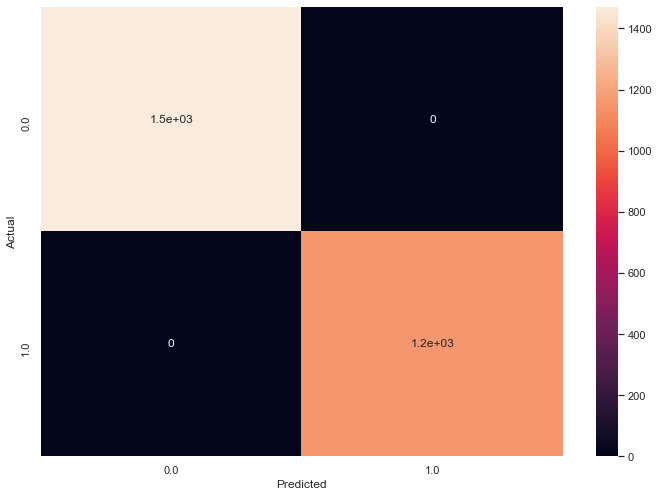

In [22]:
data = {'y_Actual':    expected,
        'y_Predicted': predicted
        }
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
cfm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.heatmap(cfm, annot=True)
plt.show()

In [23]:
cm = confusion_matrix(predicted, expected)
print('Confusion matrix')
print(cm)
print('Accuracy Score :',accuracy_score(predicted, expected))
print('Stats : ')
print(classification_report(predicted, expected))

Confusion matrix
[[1471    0]
 [   0 1155]]
Accuracy Score : 1.0
Stats : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1471
         1.0       1.00      1.00      1.00      1155

    accuracy                           1.00      2626
   macro avg       1.00      1.00      1.00      2626
weighted avg       1.00      1.00      1.00      2626

